## Extending to five Component PR EOS

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rcParams
import numpy as np
import matplotlib.cm as cm # matplotlib's color map library
#rcParams['figure.figsize'] = 18.75, 18.75
from scipy import stats
import seaborn as sns
from scipy.interpolate import griddata
import seaborn as sns
import pr_z_v9 as pr_z
#import pr_z_v7_DefaultOmega as pr_z
R, mwAir, degF2R = 10.731577089016, 28.97, 459.67
from tabulate import tabulate as tabulate

import importlib
importlib.reload(pr_z)
import pyrestoolbox as rtb
importlib.reload(rtb)

import gerg2
importlib.reload(gerg2)

<module 'gerg2' from 'C:\\Users\\vinom\\OneDrive - Santos\\Work in progress\\Python\\0-ResEng\\Z-Factors\\Inerts3\\gerg2.py'>

In [2]:
pr_z.tc_pc(16.043/28.97)

(343.0080000000004, 667.0290000000002)

In [3]:
hc_mw, degf = 16.223, 40
bips = pr_z.calc_bips(hc_mw, degf)
header = ['', 'CO2', 'H2S', 'N2', 'H2', 'HC_Gas']
rows = [[header[j+1]]+list(bips[j]) for j in range(5)]
print(tabulate(rows, header))

               CO2         H2S          N2         H2      HC_Gas
------  ----------  ----------  ----------  ---------  ----------
CO2      0           0.0523249  -0.219895   0.646848    0.0415514
H2S      0.0523249   0          -0.314059   0.65        0.0893581
N2      -0.219895   -0.314059    0          0.36917    -0.0320398
H2       0.646848    0.65        0.36917    0           0.0818982
HC_Gas   0.0415514   0.0893581  -0.0320398  0.0818982   0


In [4]:
degf, psia, sg, co2, h2s, n2, h2 = 60, 1500, 16.043/28.97, 0.0, 0.5, 0, 0
z = pr_z.peng_robinson_z(degf, psia, sg, co2=co2, h2s=h2s, n2=n2, h2 = h2)
vis = pr_z.lbc(z, degf, psia, sg, co2=co2, h2s=h2s, n2=n2, h2 = h2)
z, vis

(0.37087760321031565, 0.027325484914459797)

In [5]:
rcParams['figure.figsize'] = 9, 9

In [21]:
def Zplots(component, psat_coefics):
    rcParams['figure.figsize'] = 9, 9

    plt.plot(Zs, calc_Zs, 'o')
    plt.plot([min(Zs), max(Zs)], [min(Zs), max(Zs)], '--', c='k')
    plt.title(component+' Calculated vs GERG2008 Molar Density')
    plt.xlabel('GERG2008 Z-Factor')
    plt.ylabel('Calculated Z-Factor')
    plt.grid()
    plt.savefig('images\\'+component+'_1.png')
    plt.show()
    errs = np.abs(calc_Zs - Zs)/Zs
    print('Average Relative error:',np.mean(errs))
    print('95% of data better than error:', np.percentile(errs, 95))
    
    #errs = (calc_Zs - Zs)/Zs
    errs = (molar_densities - calc_molar_densities)/molar_densities
    plt.plot(molar_densities, errs, 'o')
    plt.title(component+' Relative Error in Calculated Molar Density')
    plt.xlabel('GERG2008 Molar Density (lb-mol/cuft)')
    plt.ylabel('(Calculated - GERG2008-Z)/GERG2008')
    plt.grid()
    plt.ylim(-0.1, 0.1)
    plt.savefig('images\\'+component+'_2.png')
    plt.show()
    
    #fig, ax = plt.subplots()
    #res = stats.probplot(errs, plot=ax)
    #ax.set_title('Normal Probability Plot of '+component+' Residuals')
    #ax.set_xlabel('Theoretical Quantiles')
    #ax.set_ylabel('Ordered Values')
    #plt.show()

    x = degfs
    y = psias
    z = errs
    
    tc, a0, a1, a2, a3 = psat_coefics
    tsat = np.arange(x[0], tc, 0.1)
    psat = a0*tsat**3+a1*tsat**2+a2*tsat+a3
    pc = a0*tc**3+a1*tc**2+a2*tc+a3

    # target grid to interpolate to
    yi = np.arange(15,15000,20)
    xi = np.arange(50, 300, 5)
    xi,yi = np.meshgrid(xi,yi)

    # interpolate
    zi = griddata((x,y), z, (xi,yi),method='linear')

    rcParams['figure.figsize'] = 11, 9
    fig, ax = plt.subplots()
    #c = ax.pcolormesh(xi, yi, zi, cmap='RdBu', vmin=zi.min(), vmax=zi.max())
    c = ax.pcolormesh(xi, yi, zi, cmap='RdBu', vmin=-0.05, vmax=0.05)
    levels = np.arange(-0.05, 0.06, 0.01)
    CS = ax.contour(xi, yi, zi, levels=levels, linewidths=0.5, colors='k')
    ax.clabel(CS, inline=True, fontsize=10)

    ax.set_title(component+' Molar Density Relative Error (Calc - GERG) / GERG')
    # set the limits of the plot to the limits of the data
    ax.axis([xi.min(), xi.max(), yi.min(), yi.max()])
    ax.set_ylabel('psia')
    ax.set_xlabel('degf')
    ax.set_ylim(0, 15000)
    ax.set_xlim(60, 300)
    
    plt.plot(tsat, psat, c='g')
    plt.plot([tc], [pc], 'o', c='g')
    
    #ax.set_ylim(0, 15)
    fig.colorbar(c, ax=ax)
    plt.savefig('images\\'+component+'_3.png')
    plt.show()
    rcParams['figure.figsize'] = 9, 9

def molar_plots(component):
    rcParams['figure.figsize'] = 9, 9
    
    plt.plot(molar_densities, calc_molar_densities, 'o')
    plt.plot([min(molar_densities), max(molar_densities)], [min(molar_densities), max(molar_densities)], '--', c='k')
    plt.title(component+' Calculated Molar Density vs GERG2008')
    plt.xlabel('GERG2008 Molar Density (lbmol/ft3)')
    plt.ylabel('Calculated Molar Density (lbmol/ft3)')
    plt.grid()
    #plt.savefig('co2.png')
    plt.show()
    errs = np.abs(calc_molar_densities - molar_densities)/molar_densities
    print('Average Relative absolute error:',np.mean(errs))
    print('95% of data better than error:', np.percentile(errs, 95))
    
    errs = (calc_molar_densities - molar_densities)/molar_densities
    plt.plot(molar_densities, errs, 'o')
    plt.title(component+' Relative Error in Calculated Molar Density')
    plt.xlabel('GERG2008 Molar Density (lbmol/ft3)')
    plt.ylabel('(Calculated - GERG2008)/GERG2008')
    plt.grid()
    plt.ylim(-0.1, 0.1)
    plt.savefig('images\\'+component+'_4.png')
    plt.show()

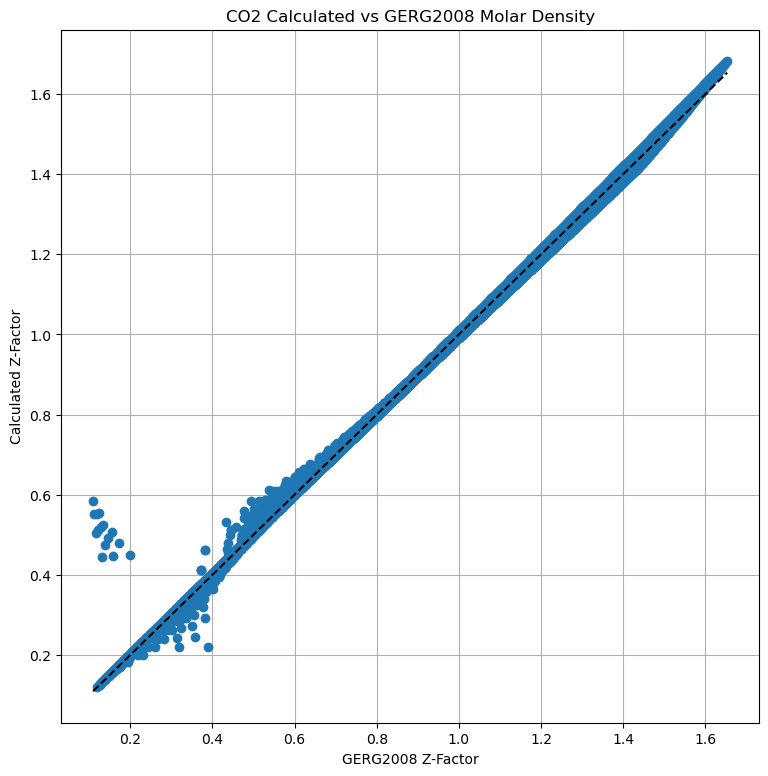

Average Relative error: 0.007612571824750346
95% of data better than error: 0.012229823902867788


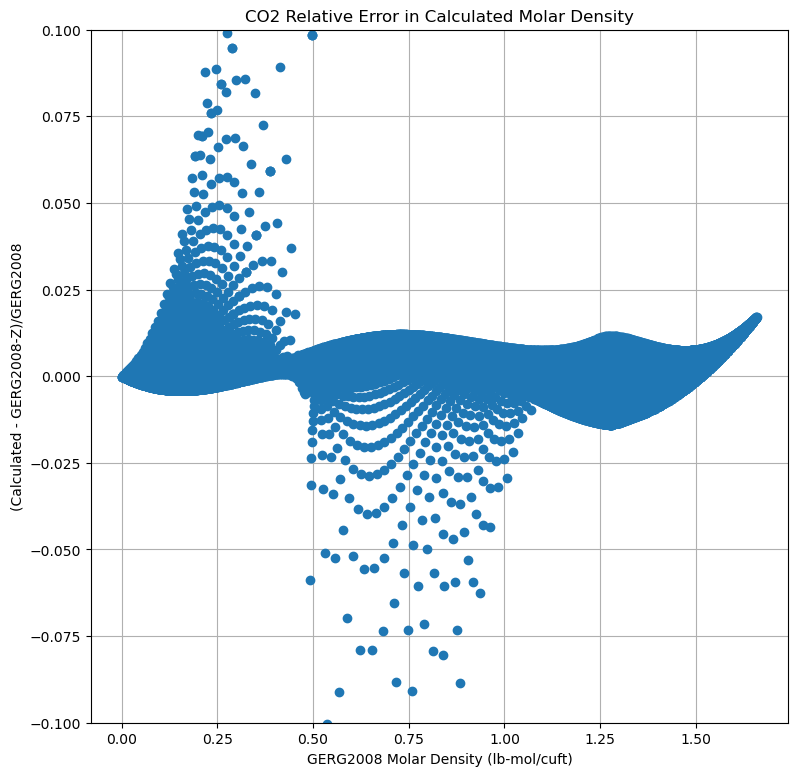

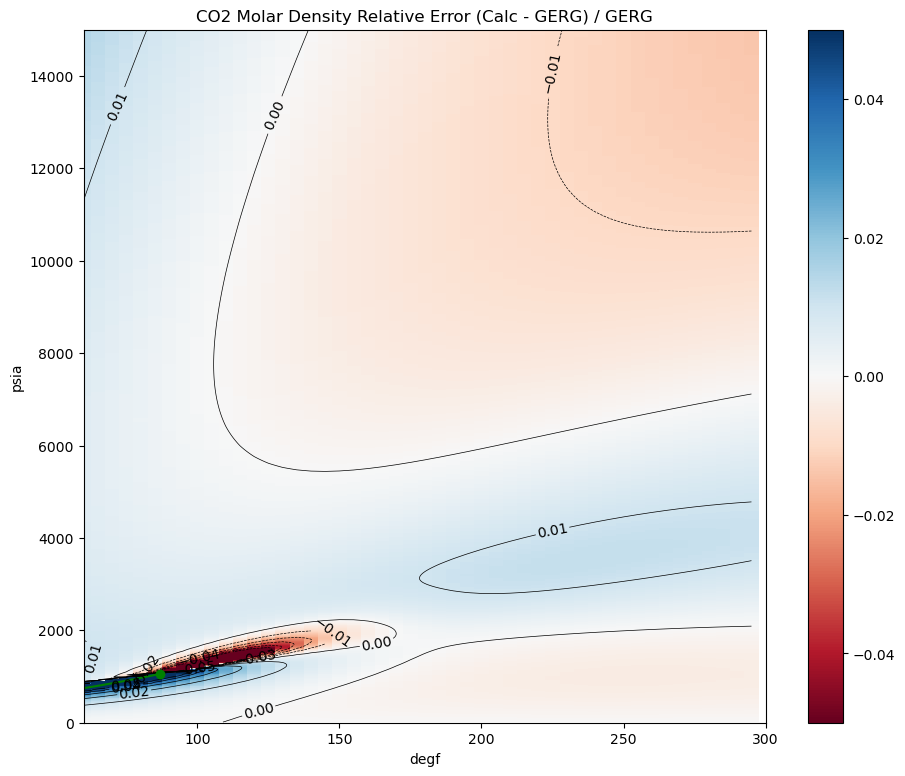

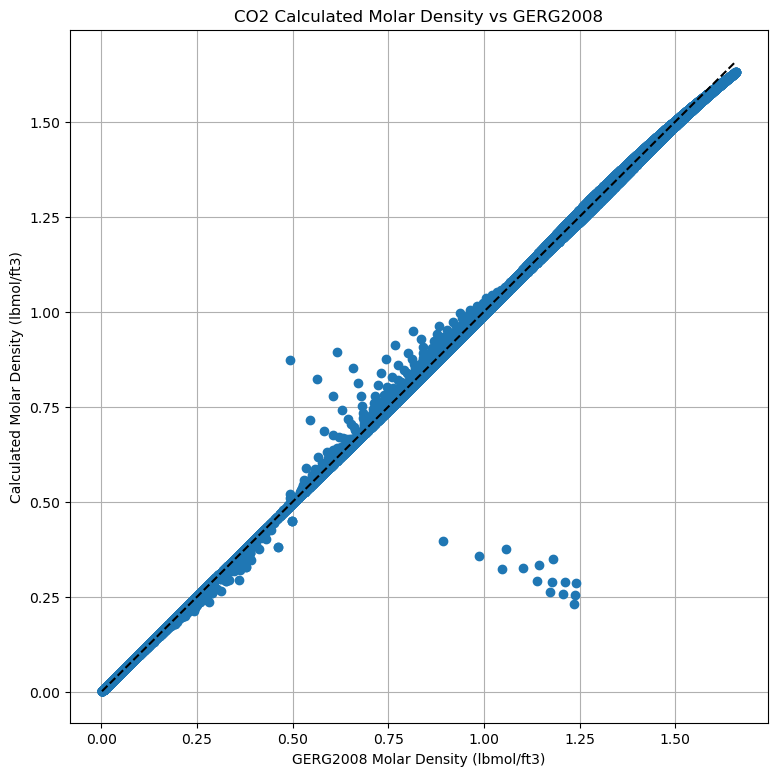

Average Relative absolute error: 0.006615471060517935
95% of data better than error: 0.012314773061740544


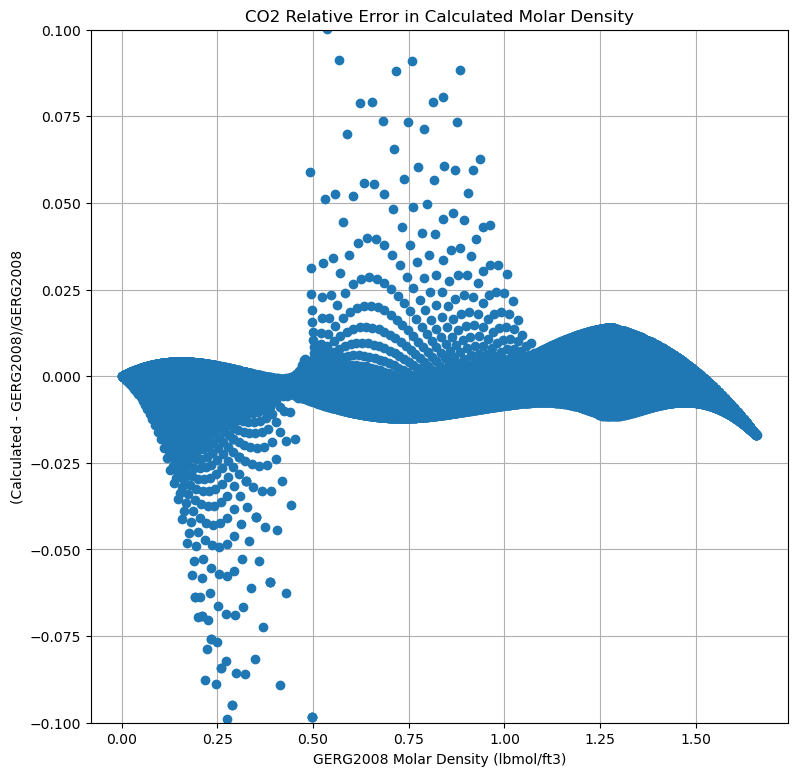

In [22]:
# Compare pure CO2
mwAir = 28.97
mwGas = 44.01
sg = mwGas/mwAir
co2, h2s, n2, h2 = 1.0, 0.0, 0.0, 0.0
df = pd.read_excel('Z-GERG_CO2.xlsx')#, sheet_name='CO2')
degfs = np.array(df['Temperature (F)'])
psias = np.array(df['Pressure (psia)'])
Zs = np.array(df['Z-Gerg'])
molar_densities = psias/(Zs*R*(degfs+degF2R)) # lb-mol/(cuft.lbm)
calc_Zs = []
for i in range(len(degfs)):
    calc_Zs.append(pr_z.peng_robinson_z(degfs[i], psias[i], sg, co2=co2, h2s=h2s, n2=n2, h2=h2))
calc_Zs = np.array(calc_Zs)
calc_molar_densities = psias/(calc_Zs*R*(degfs+degF2R))
errs = np.abs(calc_Zs - Zs)/Zs
Zplots('CO2', [87, 0.000199491, 0.016819666, 5.798738321, 296.0668442])
molar_plots('CO2')

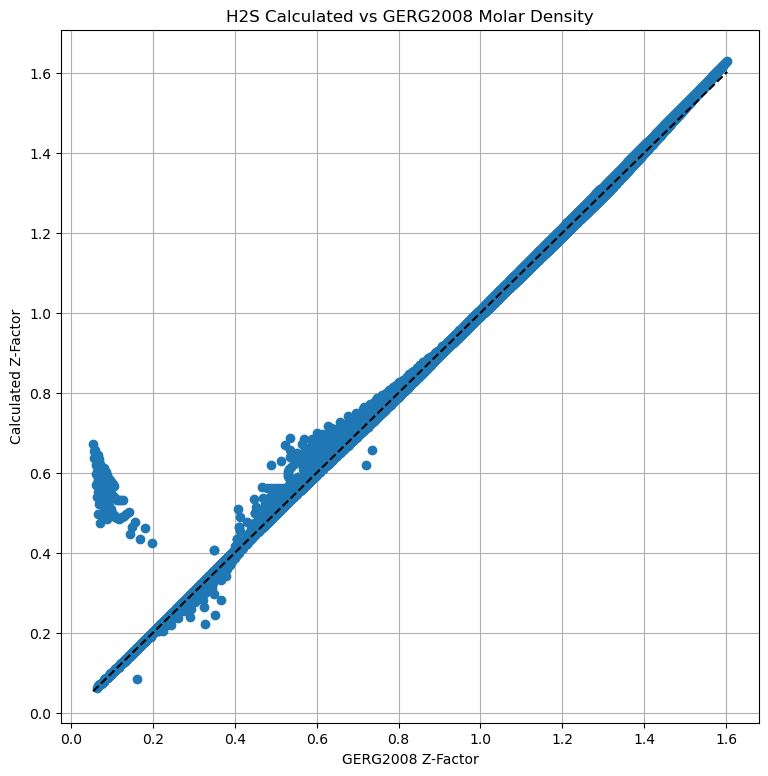

Average Relative error: 0.02102488332171363
95% of data better than error: 0.01247972745970201


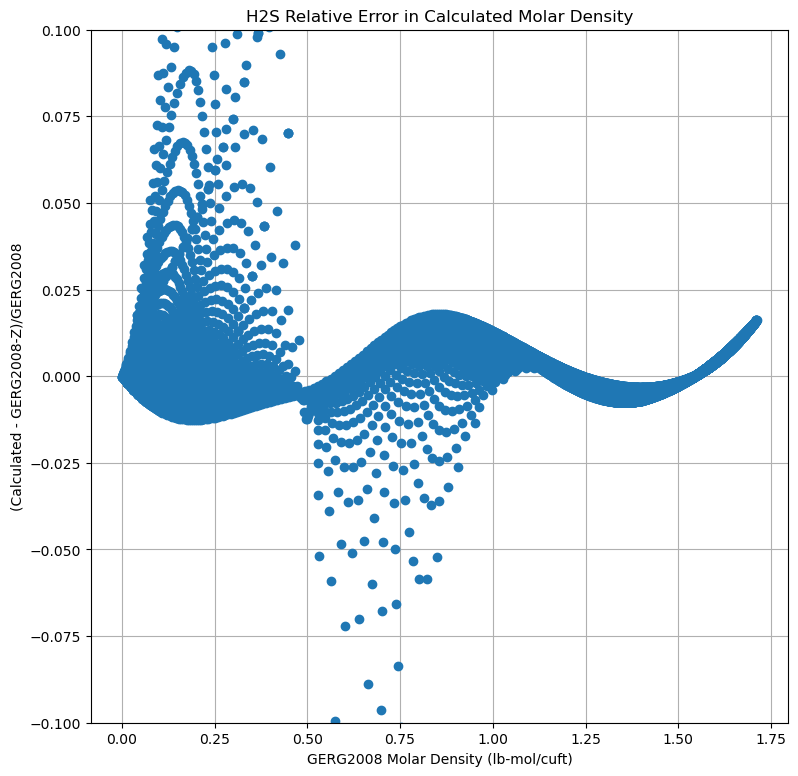

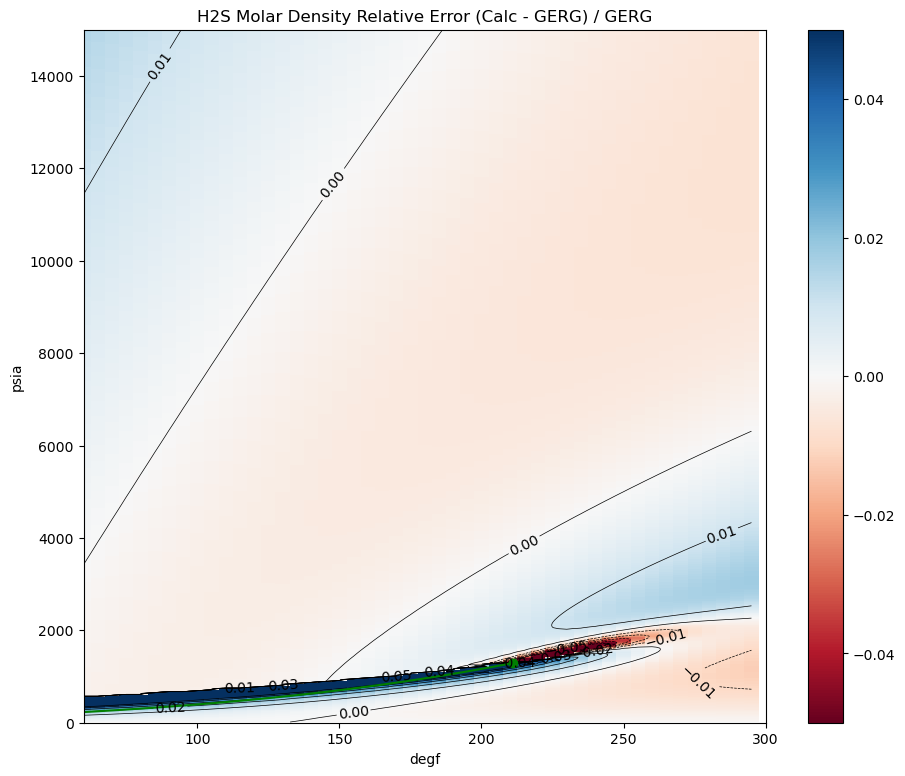

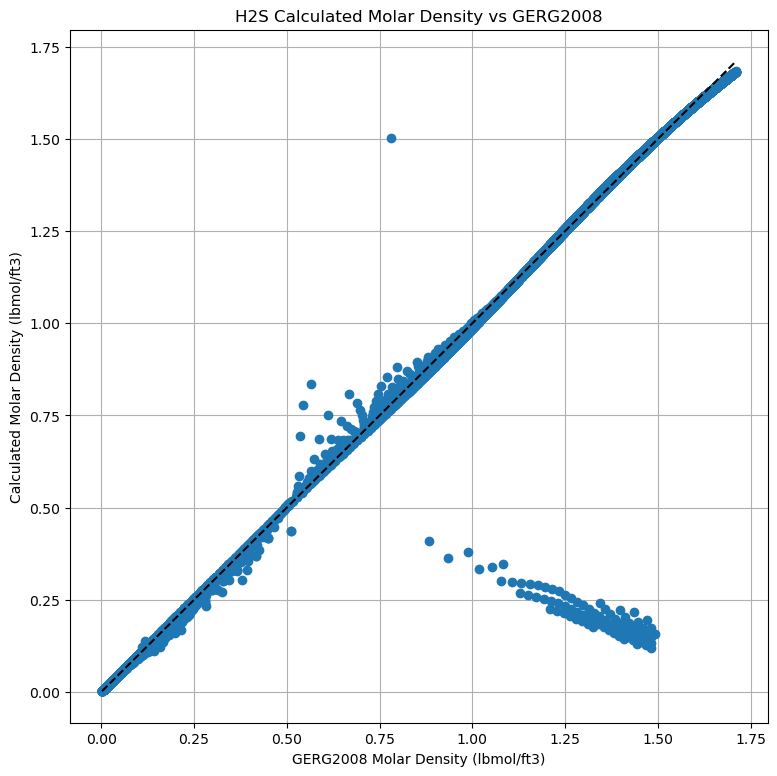

Average Relative absolute error: 0.007579705236356864
95% of data better than error: 0.012372681011451366


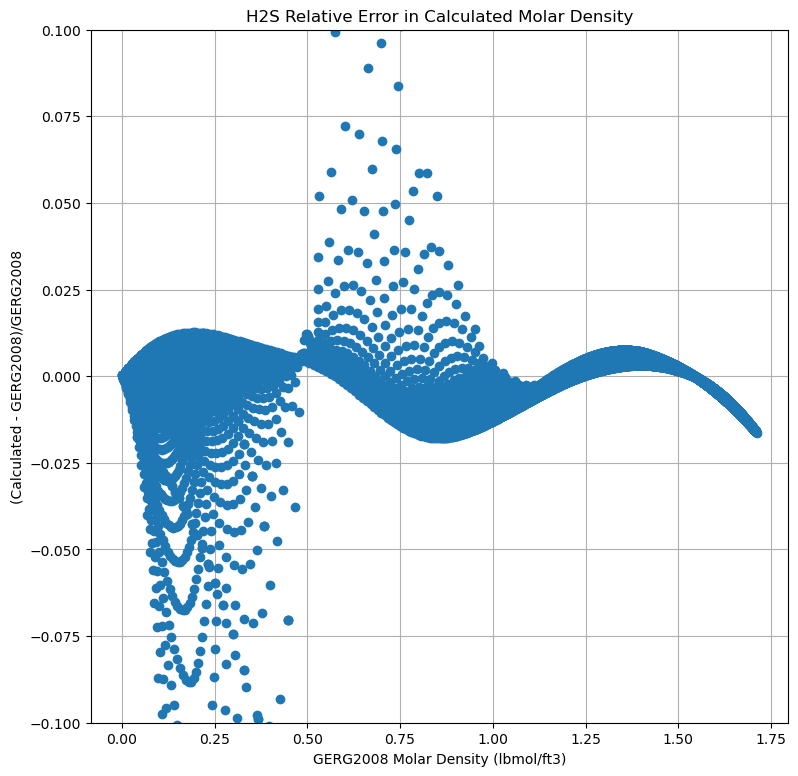

In [23]:
# Compare pure H2S
mwGas = 34.082
sg = mwGas/mwAir
co2, h2s, n2, h2 = 0.0, 1.0, 0.0, 0
df = pd.read_excel('Z-GERG_H2S.xlsx')#, sheet_name='H2S')
degfs = np.array(df['Temperature (F)'])
psias = np.array(df['Pressure (psia)'])
Zs = np.array(df['Z-Gerg'])
molar_densities = psias/(Zs*R*(degfs+degF2R)) # lb-mol/(cuft.lbm)
calc_Zs = []
for i in range(len(degfs)):
    calc_Zs.append(pr_z.peng_robinson_z(degfs[i], psias[i], sg, co2=co2, h2s=h2s, n2=n2, h2=h2))
calc_Zs = np.array(calc_Zs)
calc_molar_densities = psias/(calc_Zs*R*(degfs+degF2R))
errs = np.abs(calc_Zs - Zs)/Zs
Zplots('H2S', [211, 5.71085E-05, 0.004922, 2.219774185, 66.98795])
molar_plots('H2S')

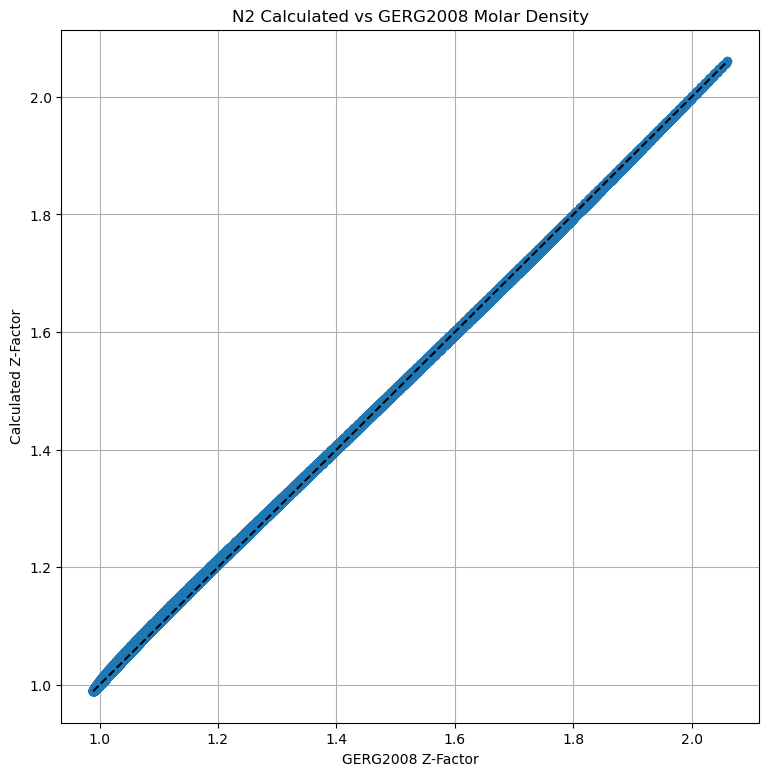

Average Relative error: 0.0037386414382105447
95% of data better than error: 0.009982630405129964


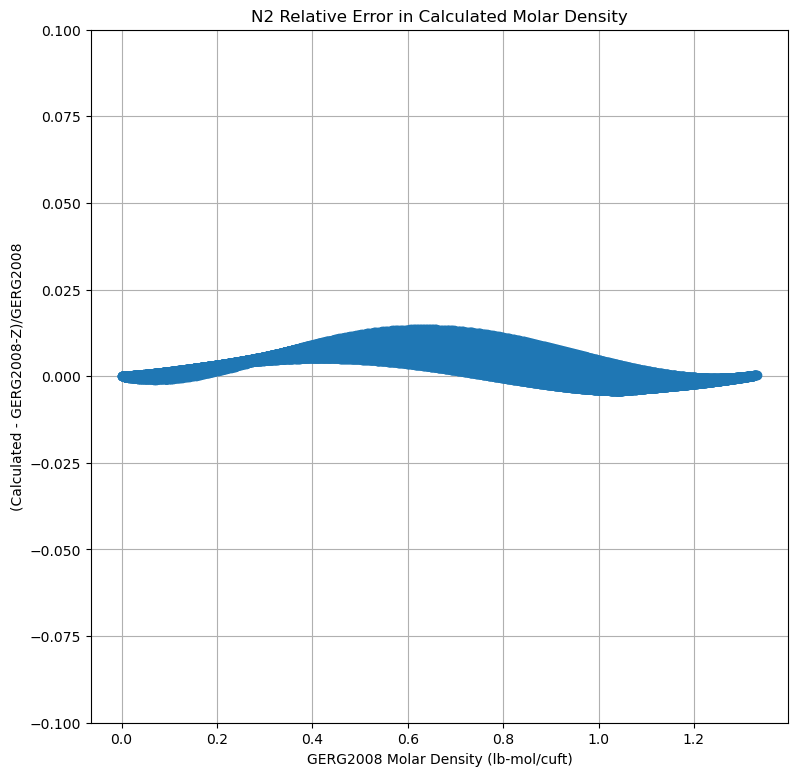

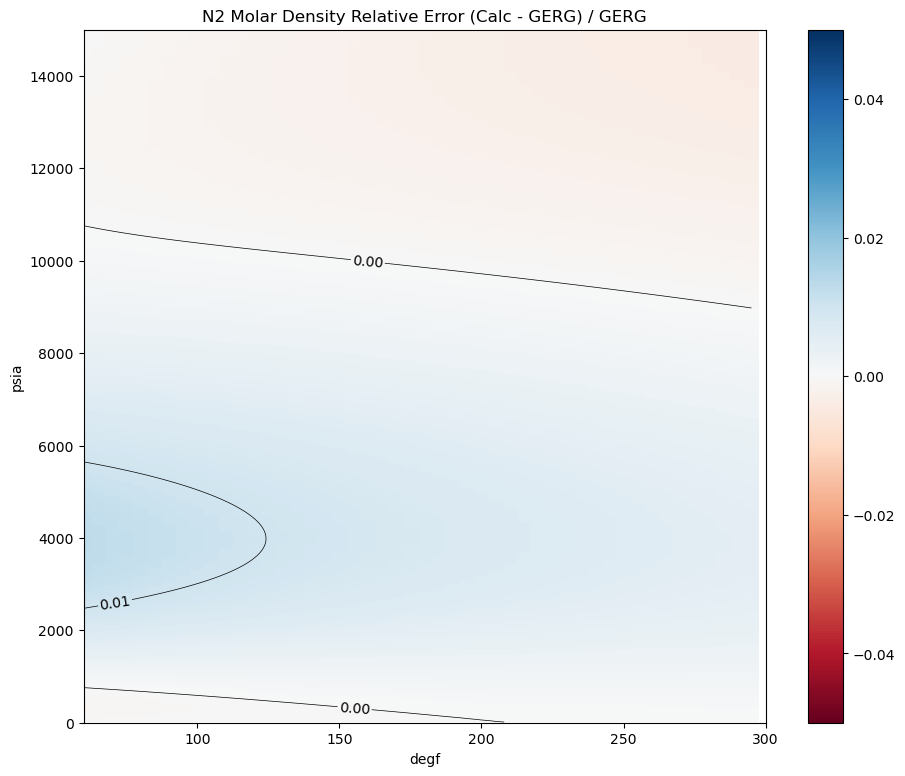

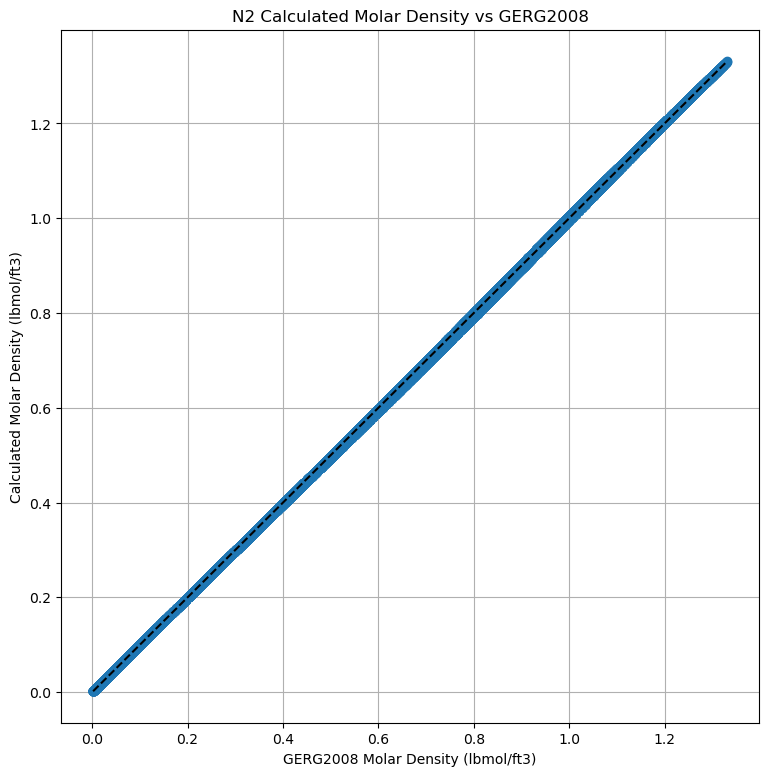

Average Relative absolute error: 0.003718683433260299
95% of data better than error: 0.00988396245957595


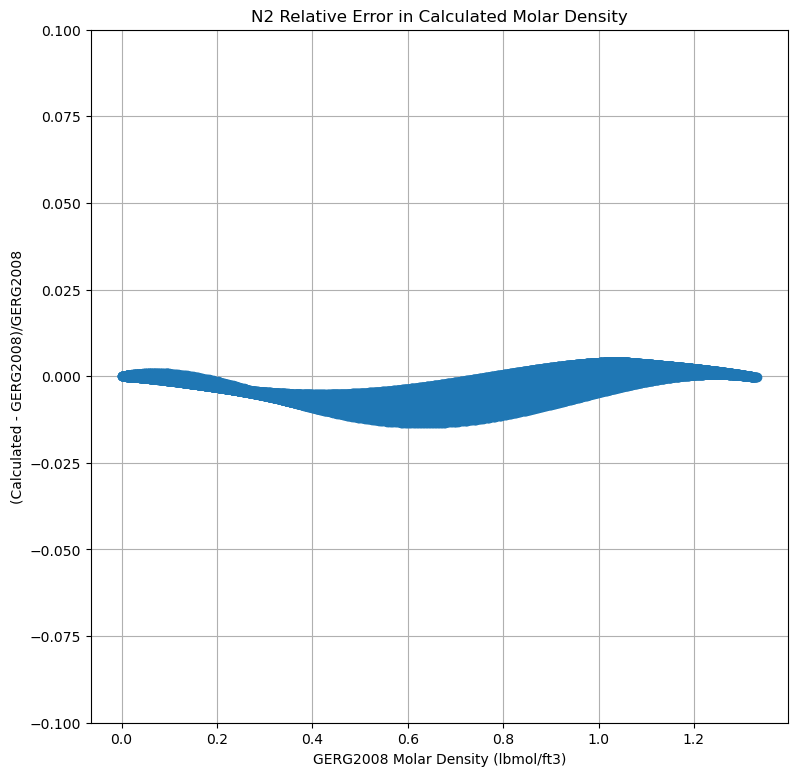

In [24]:
# Compare pure N2
mwGas = 28.014
sg = mwGas/mwAir
co2, h2s, n2, h2 = 0.0, 0.0, 1.0, 0
df = pd.read_excel('Z-GERG_N2.xlsx')#, sheet_name='N2')
degfs = np.array(df['Temperature (F)'])
psias = np.array(df['Pressure (psia)'])
Zs = np.array(df['Z-Gerg'])
molar_densities = psias/(Zs*R*(degfs+degF2R))
calc_Zs = []
for i in range(len(degfs)):
    calc_Zs.append(pr_z.peng_robinson_z(degfs[i], psias[i], sg, co2=co2, h2s=h2s, n2=n2, h2=h2))
calc_Zs = np.array(calc_Zs)
calc_molar_densities = psias/(calc_Zs*R*(degfs+degF2R))
errs = np.abs(calc_Zs - Zs)/Zs
Zplots('N2', [-233, 0.000323591, 0.333366681, 114.9031482, 13251.33895])
molar_plots('N2')

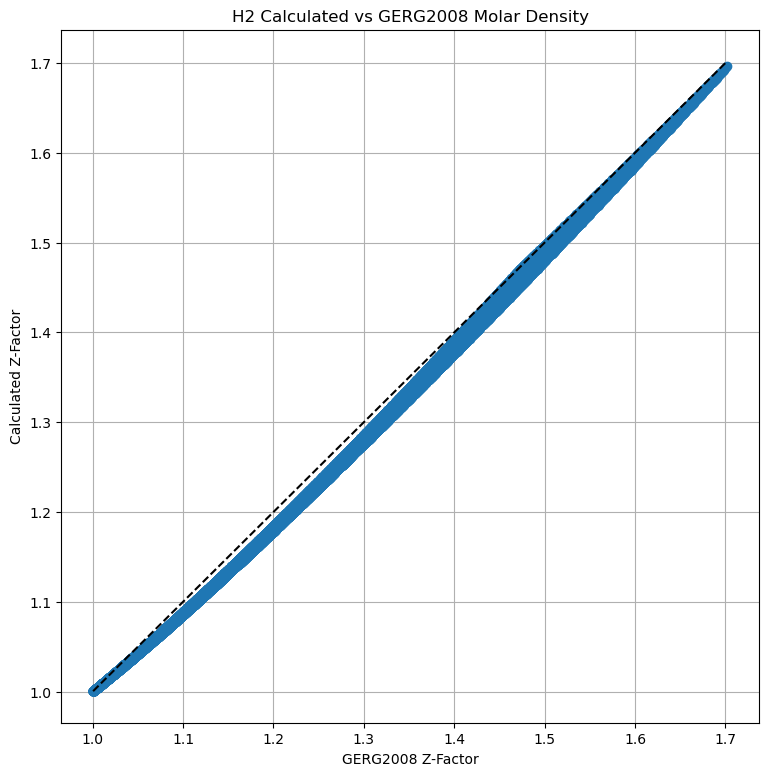

Average Relative error: 0.011016213913440492
95% of data better than error: 0.01750164100317078


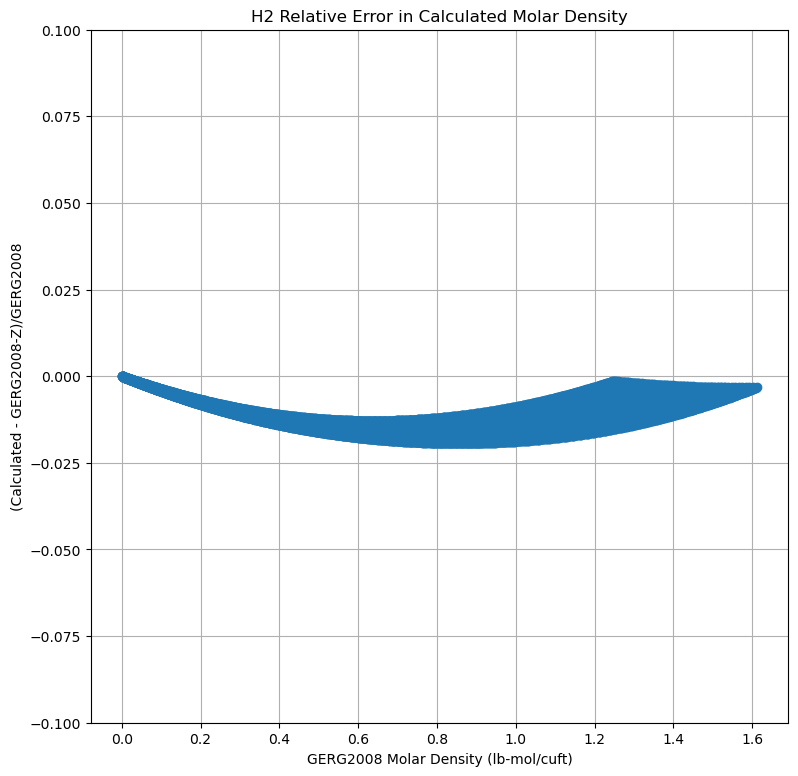

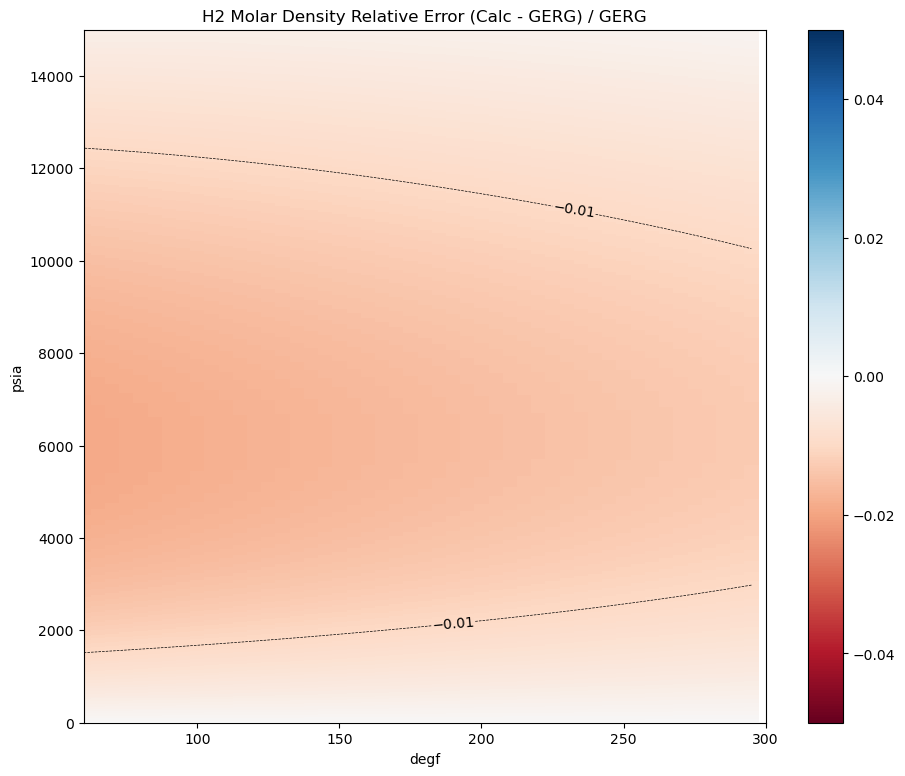

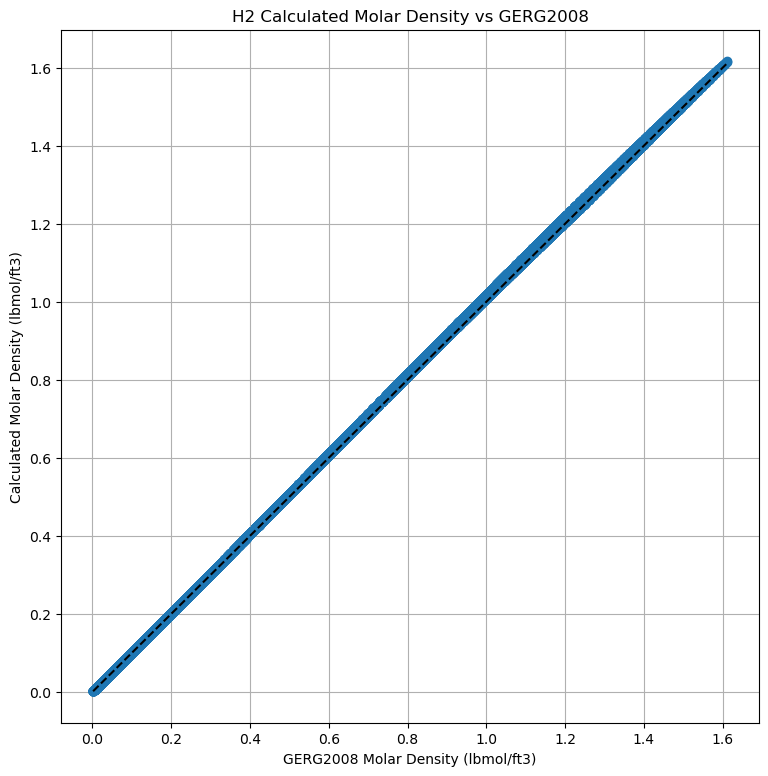

Average Relative absolute error: 0.011160105887585597
95% of data better than error: 0.017813404819364505


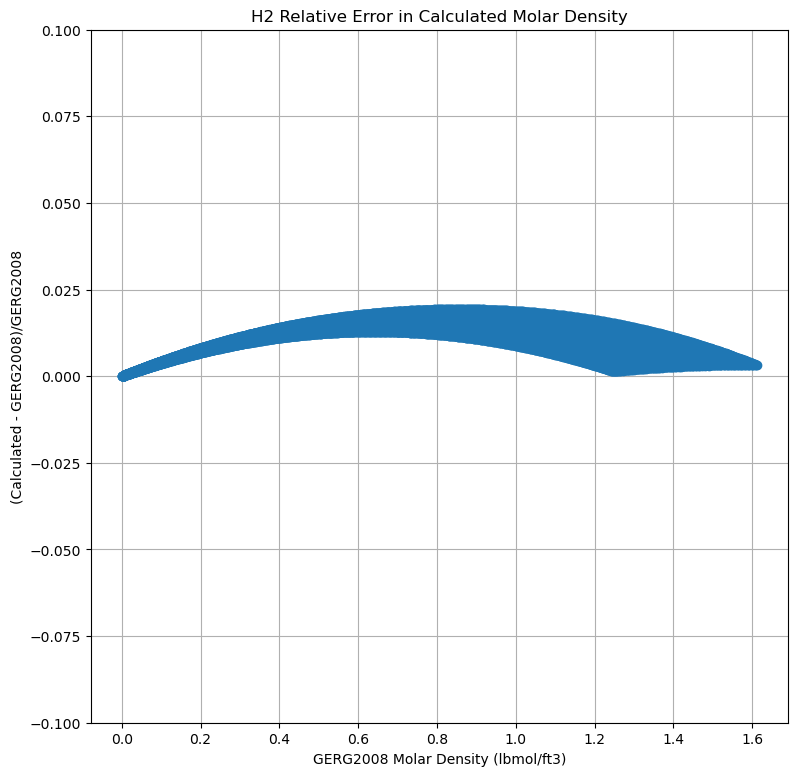

In [25]:
# Compare pure H2
mwGas = 2.016
sg = mwGas/mwAir
co2, h2s, n2, h2 = 0.0, 0.0, 0.0, 1.0
df = pd.read_excel('Z-GERG_H2.xlsx')#, sheet_name='H2')
degfs = np.array(df['Temperature (F)'])
psias = np.array(df['Pressure (psia)'])
Zs = np.array(df['Z-Gerg'])
molar_densities = psias/(Zs*R*(degfs+degF2R))
calc_Zs = []
for i in range(len(degfs)):
    calc_Zs.append(pr_z.peng_robinson_z(degfs[i], psias[i], sg, co2=co2, h2s=h2s, n2=n2, h2=h2))
calc_Zs = np.array(calc_Zs)
calc_molar_densities = psias/(calc_Zs*R*(degfs+degF2R))
errs = np.abs(calc_Zs - Zs)/Zs
Zplots('H2', [-233, 0.000323591, 0.333366681, 114.9031482, 13251.33895])
molar_plots('H2')

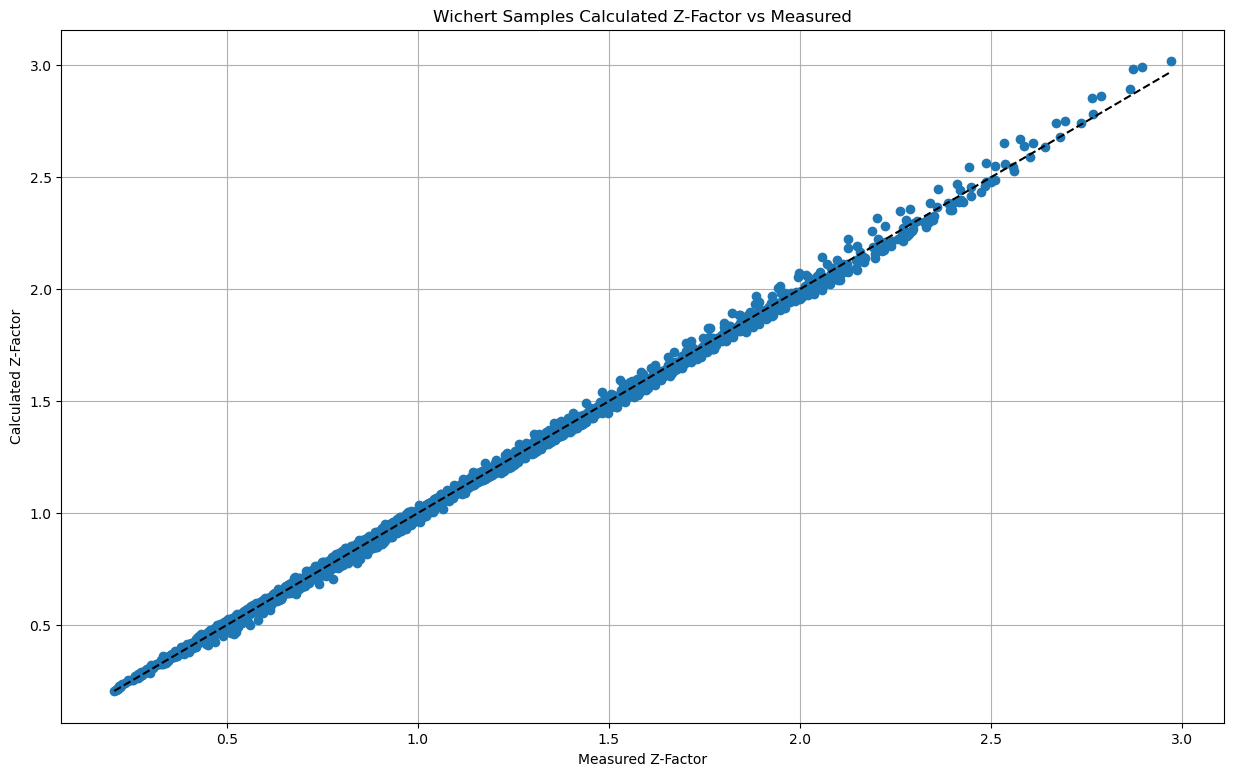

Average Relative error: 0.01273650747756219
99% of data better than error: 0.05024379756493439


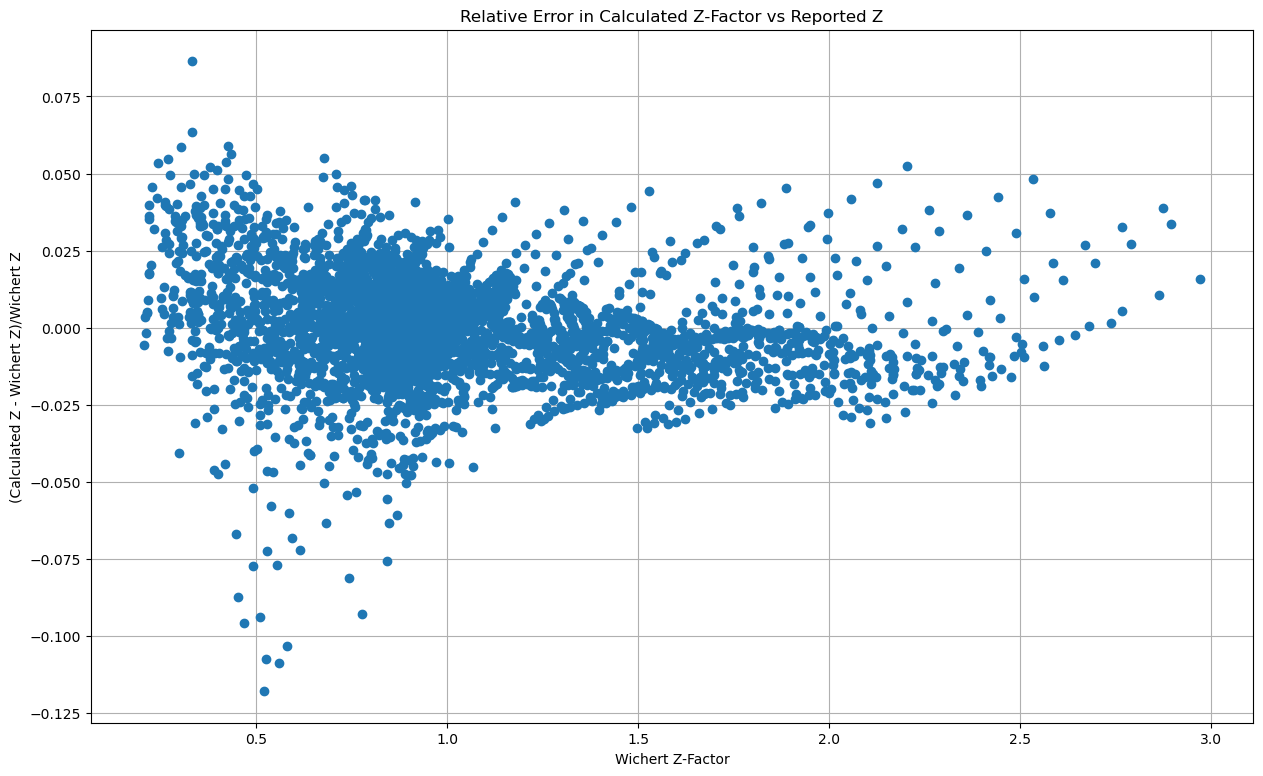

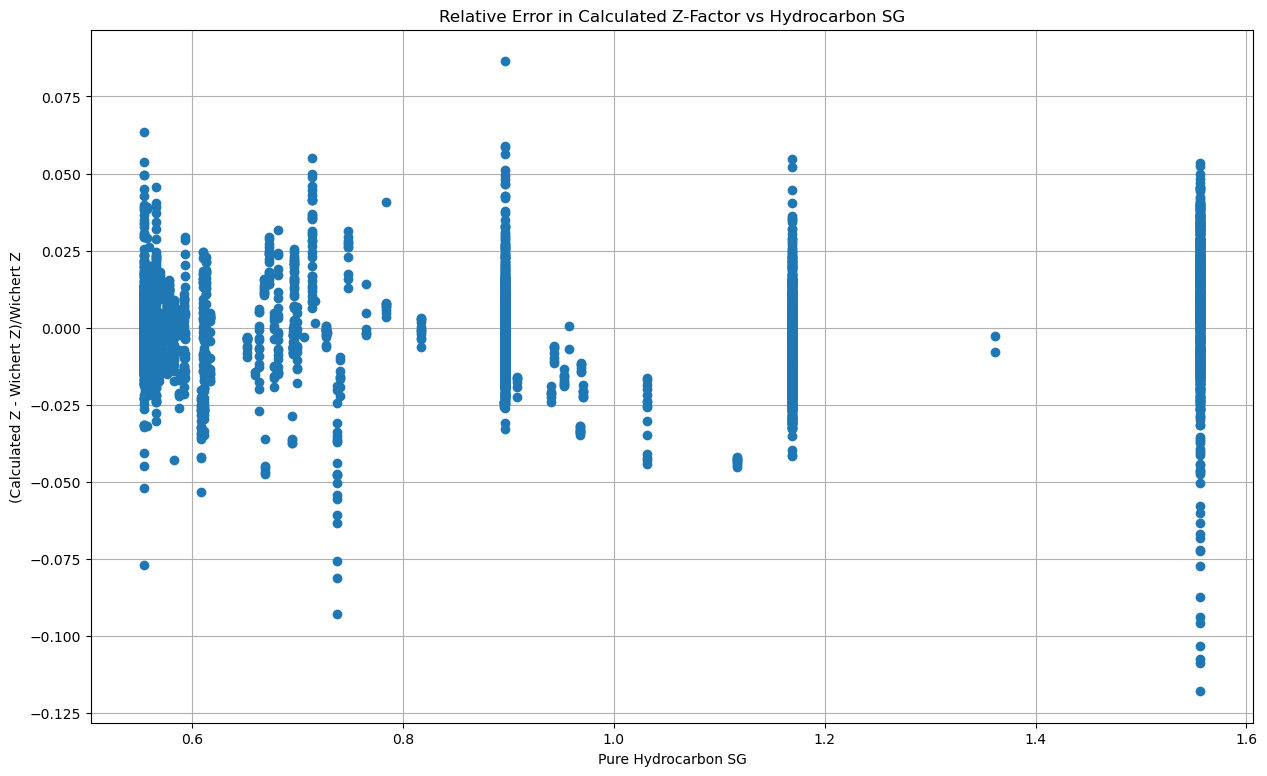

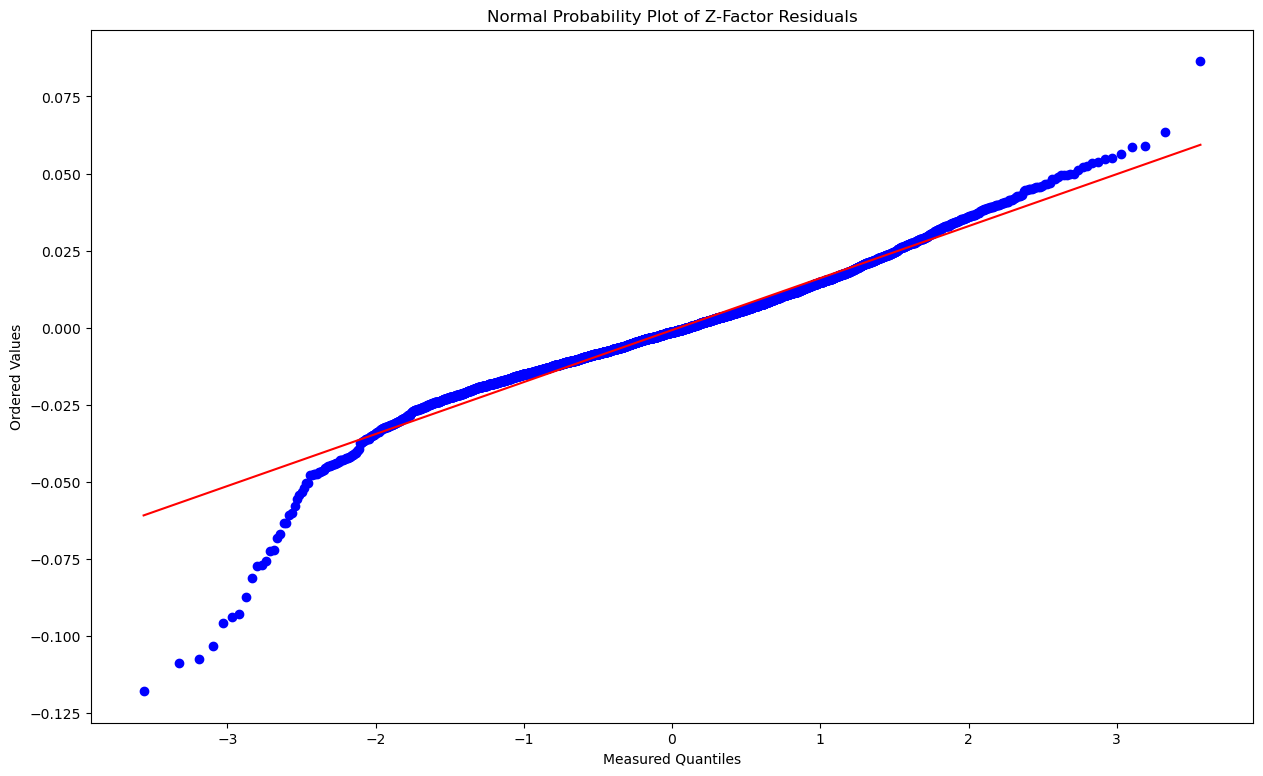

In [50]:
# Compare Wichert data
df = pd.read_excel('Wichert_data_export4.xlsx')

degfs = np.array(df['degf'])
psias = np.array(df['psia'])
sgs = np.array(df['sg'])
co2s = np.array(df['co2'])
h2ss = np.array(df['h2s'])
n2s = np.array(df['n2'])
Zs = np.array(df['Z'])

sg_hc = (sgs - (co2s * 44.01 + h2ss * 34.082 + n2s * 28.014) / mwAir) / (1 - co2s - h2ss - n2s)

calc_Zs = []
for i in range(len(degfs)):
    calc_Zs.append(pr_z.peng_robinson_z(degfs[i], psias[i], sgs[i], co2=co2s[i], h2s=h2ss[i], n2=n2s[i]))
calc_Zs = np.array(calc_Zs)

z_dak_pmc = np.array([rtb.gas_z(psias[i], sgs[i], degfs[i], zmethod='DAK', cmethod='PMC', co2 = co2s[i], h2s = h2ss[i], n2 = n2s[i] ) for i in range(len(psias))])
z_dak_sut = np.array([rtb.gas_z(psias[i], sgs[i], degfs[i], zmethod='DAK', cmethod='SUT', co2 = co2s[i], h2s = h2ss[i], n2 = n2s[i] ) for i in range(len(psias))])

plt.plot(Zs, calc_Zs, 'o')
plt.plot([min(Zs), max(Zs)], [min(Zs), max(Zs)], '--', c='k')
plt.title('Wichert Samples Calculated Z-Factor vs Measured')
plt.xlabel('Measured Z-Factor')
plt.ylabel('Calculated Z-Factor')
plt.grid()
plt.savefig('images\\'+'wichert.png')
plt.show()
errs = np.abs(calc_Zs - Zs)/Zs
print('Average Relative error:',np.mean(errs))
print('99% of data better than error:', np.percentile(errs, 99))

errs = (calc_Zs - Zs)/Zs
plt.plot(Zs, errs, 'o')
plt.title('Relative Error in Calculated Z-Factor vs Reported Z')
plt.xlabel('Wichert Z-Factor')
plt.ylabel('(Calculated Z - Wichert Z)/Wichert Z')
plt.grid()
plt.savefig('images\\'+'rel_wichert.png')
plt.show()

plt.plot(sg_hc, errs, 'o')
plt.title('Relative Error in Calculated Z-Factor vs Hydrocarbon SG')
plt.xlabel('Pure Hydrocarbon SG')
plt.ylabel('(Calculated Z - Wichert Z)/Wichert Z')
plt.grid()
plt.savefig('images\\'+'rel_wichert_HC_SG.png')
plt.show()

fig, ax = plt.subplots()
res = stats.probplot(errs, plot=ax)
ax.set_title('Normal Probability Plot of Z-Factor Residuals')
ax.set_xlabel('Measured Quantiles')
ax.set_ylabel('Ordered Values')
plt.savefig('images\\'+'norm_wichert.png')
plt.show()

In [51]:
errs = (calc_Zs - Zs)/Zs
#for i in list(np.where(np.abs(errs)>0.4)[0]):
for i in list(np.where(errs>0.05)[0]):
    print(i, errs[i], calc_Zs[i], Zs[i], degfs[i], psias[i], sgs[i], co2s[i], h2ss[i], n2s[i])

467 0.05497117946643812 0.7152704596782451 0.678 100 2526 0.8173240352088367 0.1292 0.0 0.0
1460 0.0636301619299909 0.35382025142986534 0.3326534580289141 90 1500 0.9273869520193304 0.0 0.6 0.0
1468 0.05366554443272072 0.4442279026504016 0.4216023813225931 120 2000 0.9273869520193304 0.0 0.6 0.0
2139 0.0586323849822071 0.32041834250884005 0.3026719634259304 120 1500 1.064549534000691 0.0 0.6 0.0
2146 0.05903849748791083 0.4520195583536483 0.4268207052206884 150 1500 1.064549534000691 0.0 0.6 0.0
2147 0.051134610352310955 0.4174474234744893 0.3971398328655286 150 2000 1.064549534000691 0.0 0.6 0.0
2209 0.0864440925310482 0.3622105671333717 0.3333908938558847 180 1500 1.120503969623749 0.0 0.8 0.0
2217 0.05635264954361454 0.45811054479137636 0.4336719797023257 220 2000 1.120503969623749 0.0 0.8 0.0
2881 0.05461145708603873 0.28354510465953847 0.2688621508465235 180 1500 1.174953400069037 0.0 0.8 0.0
2889 0.05212784209295466 0.4003391900112733 0.3805043208579055 220 2000 1.174953400069037

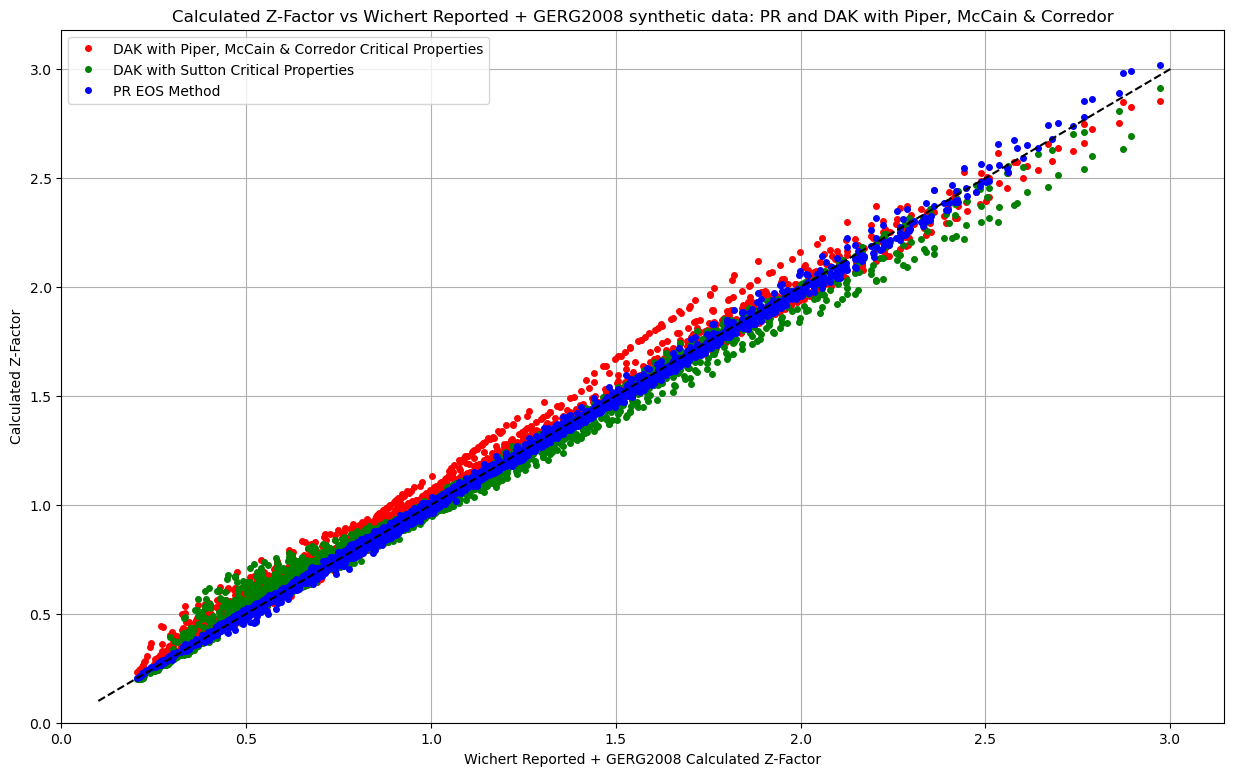

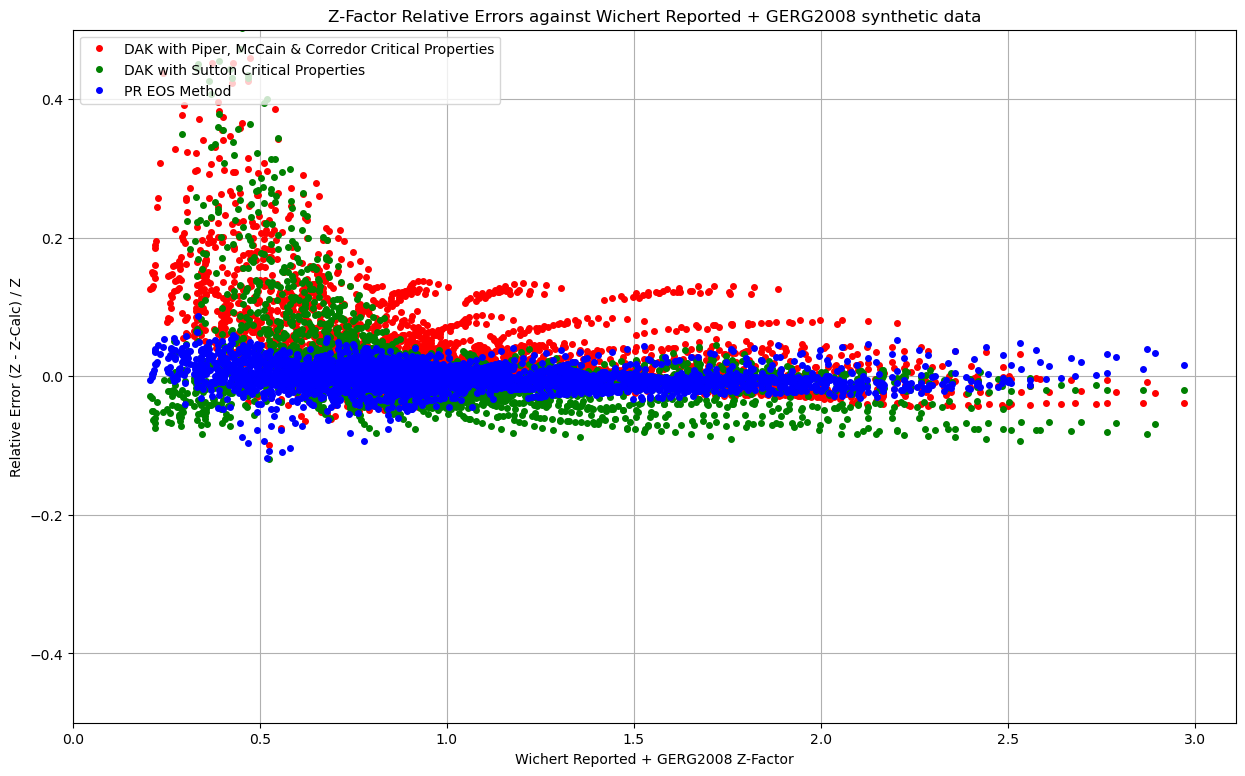

In [54]:
plt.plot(Zs, z_dak_pmc, 'o', c='r', markersize=4, label='DAK with Piper, McCain & Corredor Critical Properties')
plt.plot(Zs, z_dak_sut, 'o', c='g', markersize=4, label='DAK with Sutton Critical Properties')
plt.plot(Zs, calc_Zs, 'o', c='b', markersize=4, label='PR EOS Method')
plt.xlabel('Wichert Reported + GERG2008 Calculated Z-Factor')
plt.ylabel('Calculated Z-Factor')
plt.plot([0.1, 3], [0.1, 3], '--', c='k')
plt.ylim(0, None)
plt.xlim(0, None)
plt.grid()
plt.title('Calculated Z-Factor vs Wichert Reported + GERG2008 synthetic data: PR and DAK with Piper, McCain & Corredor')
plt.legend(loc='upper left')
plt.savefig('images\\'+'Crossplot_Z-PR_DAK_extended.png')
plt.show()

pr_er = (calc_Zs - Zs)/Zs
dak_sut_err = (z_dak_sut - Zs)/Zs
dak_pmc_err = (z_dak_pmc - Zs)/Zs

plt.plot(Zs, dak_pmc_err, 'o', c='r', markersize=4, label='DAK with Piper, McCain & Corredor Critical Properties')
plt.plot(Zs, dak_sut_err, 'o', c='g', markersize=4, label='DAK with Sutton Critical Properties')
plt.plot(Zs, pr_er, 'o', c='b', markersize=4, label='PR EOS Method')
plt.xlabel('Wichert Reported + GERG2008 Z-Factor')
plt.ylabel('Relative Error (Z - Z-Calc) / Z')
#plt.plot([0.1, 3], [0.1, 3], '--', c='k')
plt.ylim(-0.5, 0.5)
plt.xlim(0, None)
plt.grid()
plt.title('Z-Factor Relative Errors against Wichert Reported + GERG2008 synthetic data')
plt.legend(loc='upper left')
plt.savefig('images\\'+'Relative_Errors.png')
plt.show()

In [29]:
pr_er = (calc_Zs - Zs)/Zs
dak_sut_err = (z_dak_sut - Zs)/Zs
dak_pmc_err = (z_dak_pmc - Zs)/Zs

errs = [pr_er, dak_sut_err, dak_pmc_err]
names = ['Peng Robinson', 'DAK + Sutton & Wichert', 'DAK + PMC']
for e, err in enumerate(errs):
    avg = np.mean(err)
    maxerr = max(err)
    print(names[e], 'Avg Rel. Error: '+str(round(avg, 3))+', Max rel. Error: '+str(round(maxerr, 3))+', 95% Errors less than ', str(round(np.percentile(err, 95),4)))

Peng Robinson Avg Rel. Error: -0.001, Max rel. Error: 0.086, 95% Errors less than  0.0279
DAK + Sutton & Wichert Avg Rel. Error: 0.004, Max rel. Error: 0.556, 95% Errors less than  0.1037
DAK + PMC Avg Rel. Error: 0.033, Max rel. Error: 0.651, 95% Errors less than  0.1508


              psia         Z      degf       co2       h2s        n2  \
psia      1.000000  0.877833  0.069848  0.070856  0.019974  0.096651   
Z         0.877833  1.000000  0.080260 -0.047990 -0.216797  0.268334   
degf      0.069848  0.080260  1.000000  0.024373  0.011313  0.043651   
co2       0.070856 -0.047990  0.024373  1.000000 -0.347743 -0.297155   
h2s       0.019974 -0.216797  0.011313 -0.347743  1.000000 -0.320987   
n2        0.096651  0.268334  0.043651 -0.297155 -0.320987  1.000000   
sg_hc     0.179073  0.129648  0.100328  0.098915  0.027931  0.151216   
Residual -0.082614 -0.161844 -0.089177  0.055921  0.191796  0.073341   

             sg_hc  Residual  
psia      0.179073 -0.082614  
Z         0.129648 -0.161844  
degf      0.100328 -0.089177  
co2       0.098915  0.055921  
h2s       0.027931  0.191796  
n2        0.151216  0.073341  
sg_hc     1.000000  0.092575  
Residual  0.092575  1.000000  


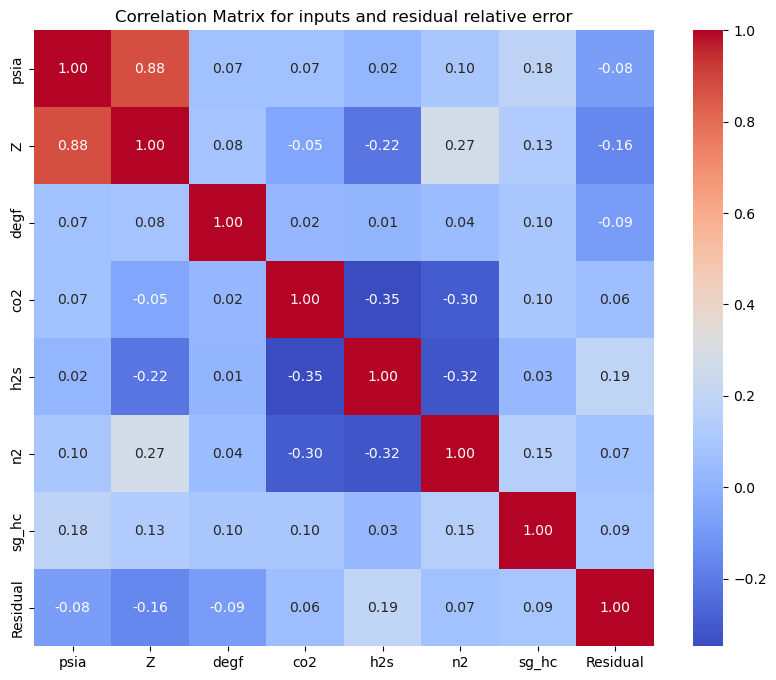

In [30]:
errs = (calc_Zs - Zs)/Zs
to_drop = ['Sample', 'Source', 'C1', 'C2', 'C3', 'iC4', 'nC4', 'iC5', 'nC5', 'C6', 'C7', 'C8', 'C9', 'C10']
for drop in to_drop:
    try:
        df.drop(columns = [drop], inplace=True)
    except:
        pass
df['sg_hc'] = (df['sg'] - (df['co2'] * 44.01 + df['h2s'] * 34.082 + df['n2'] * 28.014) / 28.97) / (1 - df['co2'] - df['h2s'] - df['n2'])
df.drop(columns = ['sg'], inplace=True)
df['Residual'] = errs
correlation_matrix = df.corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for inputs and residual relative error')
plt.savefig('images\\'+'corel_wichert.png')
plt.show()

              psia         Z      degf       co2       h2s        n2  \
psia      1.000000  0.877833  0.069848  0.070856  0.019974  0.096651   
Z         0.877833  1.000000  0.080260 -0.047990 -0.216797  0.268334   
degf      0.069848  0.080260  1.000000  0.024373  0.011313  0.043651   
co2       0.070856 -0.047990  0.024373  1.000000 -0.347743 -0.297155   
h2s       0.019974 -0.216797  0.011313 -0.347743  1.000000 -0.320987   
n2        0.096651  0.268334  0.043651 -0.297155 -0.320987  1.000000   
sg_hc     0.179073  0.129648  0.100328  0.098915  0.027931  0.151216   
Residual  0.892738  0.995130  0.078552 -0.051968 -0.169207  0.264091   

             sg_hc  Residual  
psia      0.179073  0.892738  
Z         0.129648  0.995130  
degf      0.100328  0.078552  
co2       0.098915 -0.051968  
h2s       0.027931 -0.169207  
n2        0.151216  0.264091  
sg_hc     1.000000  0.168959  
Residual  0.168959  1.000000  


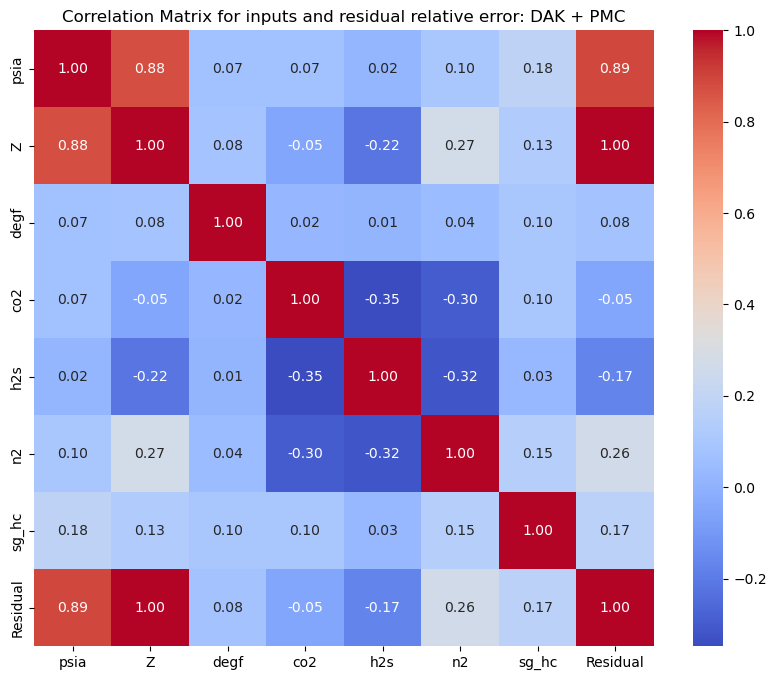

In [31]:
# DAK + PMC
errs = z_dak_pmc
df['Residual'] = errs
correlation_matrix = df.corr()
print(correlation_matrix)


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for inputs and residual relative error: DAK + PMC')
plt.savefig('images\\'+'corel_wichert_DAK_PMC.png')
plt.show()

              psia         Z      degf       co2       h2s        n2  \
psia      1.000000  0.877833  0.069848  0.070856  0.019974  0.096651   
Z         0.877833  1.000000  0.080260 -0.047990 -0.216797  0.268334   
degf      0.069848  0.080260  1.000000  0.024373  0.011313  0.043651   
co2       0.070856 -0.047990  0.024373  1.000000 -0.347743 -0.297155   
h2s       0.019974 -0.216797  0.011313 -0.347743  1.000000 -0.320987   
n2        0.096651  0.268334  0.043651 -0.297155 -0.320987  1.000000   
sg_hc     0.179073  0.129648  0.100328  0.098915  0.027931  0.151216   
Residual  0.876043  0.995424  0.086090 -0.054103 -0.236427  0.278090   

             sg_hc  Residual  
psia      0.179073  0.876043  
Z         0.129648  0.995424  
degf      0.100328  0.086090  
co2       0.098915 -0.054103  
h2s       0.027931 -0.236427  
n2        0.151216  0.278090  
sg_hc     1.000000  0.121858  
Residual  0.121858  1.000000  


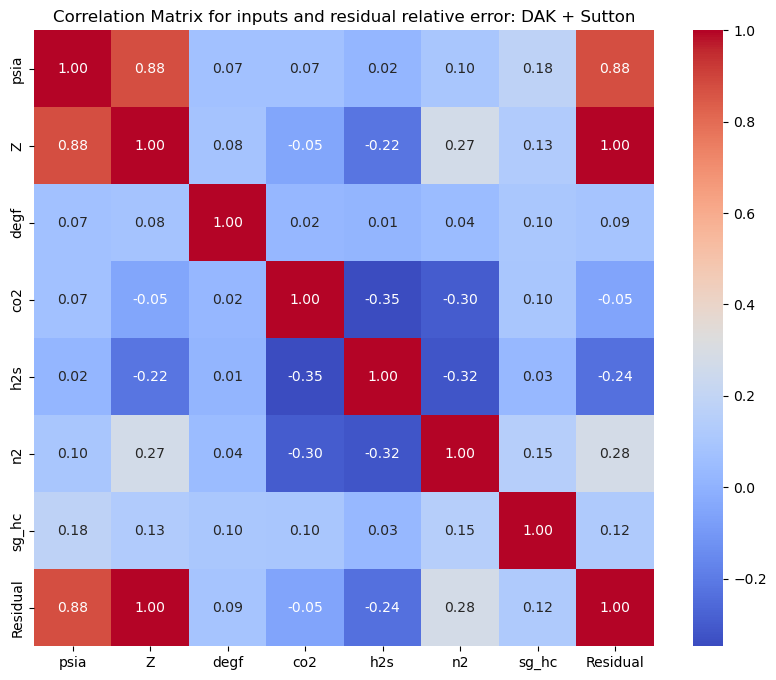

In [32]:
# DAK + Sutton & Wichert
errs = z_dak_sut
df['Residual'] = errs
correlation_matrix = df.corr()
print(correlation_matrix)


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for inputs and residual relative error: DAK + Sutton')
plt.savefig('images\\'+'corel_wichert_DAK_PMC.png')
plt.show()

In [33]:
errs = (calc_Zs - Zs)/Zs
for i in list(np.where(np.abs(errs)>0.15)[0]):
    print(i, errs[i], degfs[i], psias[i], sgs[i], co2s[i], h2ss[i], n2s[i])
    

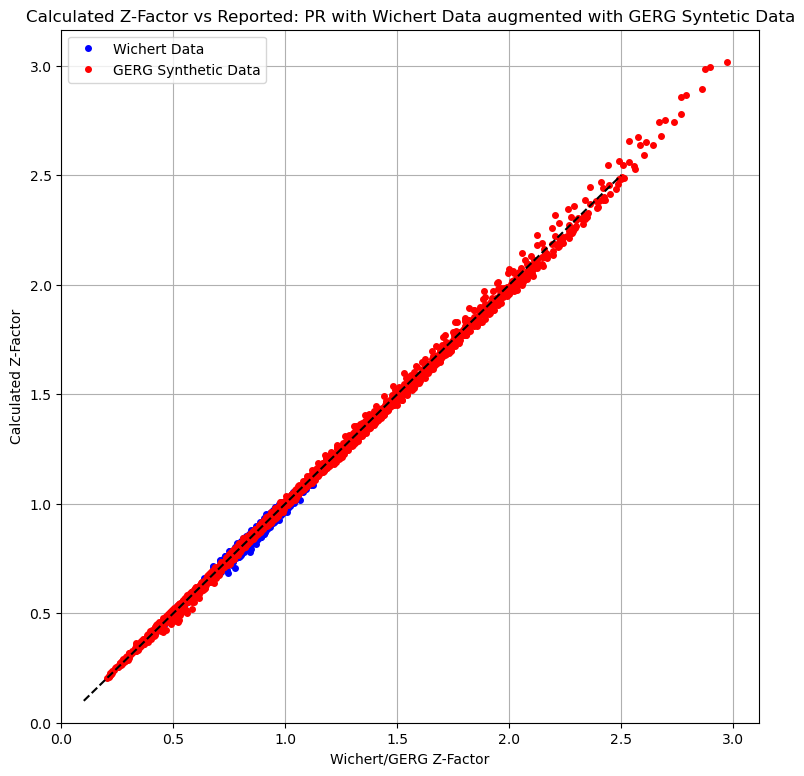

In [34]:
# Compare Wichert & synthetic GERG data
df = pd.read_excel('Wichert_data_export4.xlsx')
filtered = df[df['Source'] == 'Wichert']

degfs = np.array(filtered['degf'])
psias = np.array(filtered['psia'])
sgs = np.array(filtered['sg'])
co2s = np.array(filtered['co2'])
h2ss = np.array(filtered['h2s'])
n2s = np.array(filtered['n2'])
Zs = np.array(filtered['Z'])

calc_Zs = []
for i in range(len(degfs)):
    calc_Zs.append(pr_z.peng_robinson_z(degfs[i], psias[i], sgs[i], co2=co2s[i], h2s=h2ss[i], n2=n2s[i]))
calc_Zs = np.array(calc_Zs)
plt.plot(Zs, calc_Zs, 'o', c='b', markersize=4, label='Wichert Data')

filtered = df[df['Source'] == 'GERG']

degfs = np.array(filtered['degf'])
psias = np.array(filtered['psia'])
sgs = np.array(filtered['sg'])
co2s = np.array(filtered['co2'])
h2ss = np.array(filtered['h2s'])
n2s = np.array(filtered['n2'])
Zs = np.array(filtered['Z'])

calc_Zs = []
for i in range(len(degfs)):
    calc_Zs.append(pr_z.peng_robinson_z(degfs[i], psias[i], sgs[i], co2=co2s[i], h2s=h2ss[i], n2=n2s[i]))
calc_Zs = np.array(calc_Zs)
plt.plot(Zs, calc_Zs, 'o', c='r', markersize=4, label='GERG Synthetic Data')

plt.xlabel('Wichert/GERG Z-Factor')
plt.ylabel('Calculated Z-Factor')
plt.plot([0.1, 2.5], [0.1, 2.5], '--', c='k')
plt.ylim(0, None)
plt.xlim(0, None)
plt.grid()
plt.title('Calculated Z-Factor vs Reported: PR with Wichert Data augmented with GERG Syntetic Data')
plt.legend(loc='upper left')
plt.savefig('images\\'+'Crossplot_Z-PR_GERG&Wichert.png')
plt.show()

# Against 'pure' Wichert data only, contracts PR and GERG2008 Z-Factor predictions
## Note: Wichert data given to C7+ has been extended to C10+ assuming exponential relationship, and C10 properties used for C10+

PR predictions as good, if not slightly better on average

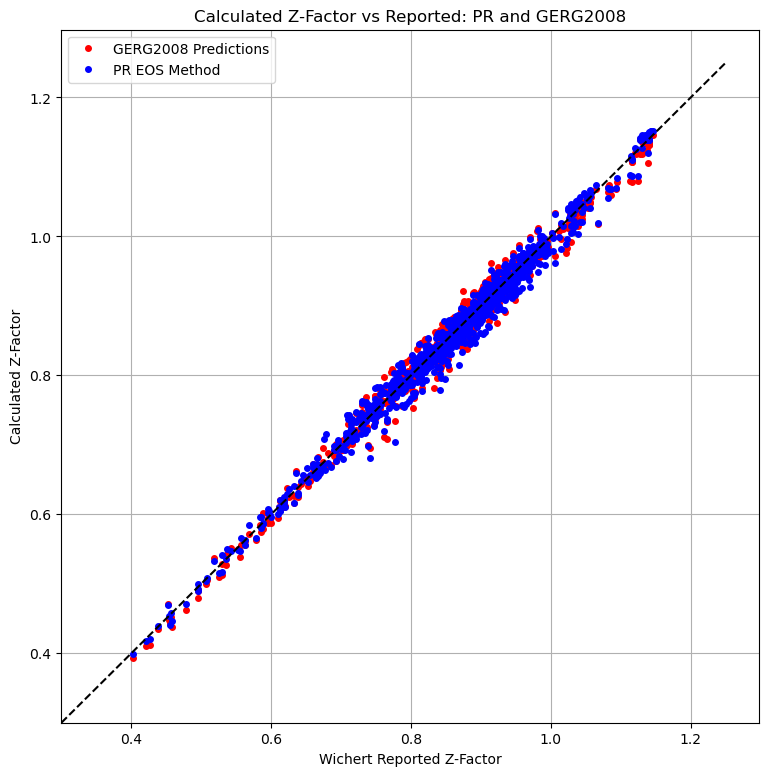

In [35]:
# Compare Wichert data only, including GERG2008 predictions against Wichert mixtures
df = pd.read_excel('Wichert_data_export4.xlsx')
filtered = df[df['Source'] == 'Wichert']

degfs = np.array(filtered['degf'])
psias = np.array(filtered['psia'])
sgs = np.array(filtered['sg'])
co2s = np.array(filtered['co2'])
h2ss = np.array(filtered['h2s'])
n2s = np.array(filtered['n2'])
Zs = np.array(filtered['Z'])

c1s = np.array(filtered['C1'])
c2s = np.array(filtered['C2'])
c3s = np.array(filtered['C3'])
ic4s = np.array(filtered['iC4'])
nc4s = np.array(filtered['nC4'])
ic5s = np.array(filtered['iC5'])
nc5s = np.array(filtered['nC5'])
c6s = np.array(filtered['C6'])
c7s = np.array(filtered['C7'])
c8s = np.array(filtered['C8'])
c9s = np.array(filtered['C9'])
c10s = np.array(filtered['C9'])
yis = [np.array([c1s[i], c2s[i], c3s[i], ic4s[i], nc4s[i], ic5s[i], nc5s[i], c6s[i], c7s[7], c8s[i], c9s[i], c10s[i]]) for i in range(len(c1s))]
       
GERG_Zs = []
calc_Zs = []
       
for i in range(len(degfs)):
    calc_Zs.append(pr_z.peng_robinson_z(degfs[i], psias[i], sgs[i], co2=co2s[i], h2s=h2ss[i], n2=n2s[i]))
    GERG_Zs.append(gerg2.gerg_z2(psias[i], degfs[i], yis[i], co2=co2s[i], h2s=h2ss[i], n2=n2s[i], h2 = 0))
calc_Zs = np.array(calc_Zs)

#z_dak_pmc = np.array([rtb.gas_z(psias[i], sgs[i], degfs[i], zmethod='DAK', cmethod='PMC', co2 = co2s[i], h2s = h2ss[i], n2 = n2s[i] ) for i in range(len(psias))])
#z_dak_sut = np.array([rtb.gas_z(psias[i], sgs[i], degfs[i], zmethod='DAK', cmethod='SUT', co2 = co2s[i], h2s = h2ss[i], n2 = n2s[i] ) for i in range(len(psias))])

#plt.plot(Zs, z_dak_pmc, 'o', c='r', markersize=4, label='DAK with Piper, McCain & Corredor Critical Properties')
#plt.plot(Zs, z_dak_sut, 'o', c='g', markersize=4, label='DAK with Sutton Critical Properties')
plt.plot(Zs, GERG_Zs, 'o', c='r', markersize=4, label='GERG2008 Predictions')
plt.plot(Zs, calc_Zs, 'o', c='b', markersize=4, label='PR EOS Method')

plt.xlabel('Wichert Reported Z-Factor')
plt.ylabel('Calculated Z-Factor')
plt.plot([0.3, 1.25], [0.3, 1.25], '--', c='k')
plt.ylim(0.3, None)
plt.xlim(0.3, None)
plt.grid()
plt.title('Calculated Z-Factor vs Reported: PR and GERG2008')

plt.legend(loc='upper left')
plt.savefig('images\\'+'Crossplot_Z-PR_GERG.png')
plt.show()

In [36]:
pr_er = (calc_Zs - Zs)/Zs
GERG_Zs = np.array(GERG_Zs)
gerg_err = (GERG_Zs - Zs)/Zs

errs = [pr_er, gerg_err]
names = ['Peng Robinson', 'GERG2008']
for e, err in enumerate(errs):
    avg = np.mean(err)
    maxerr = max(err)
    print(names[e], 'Avg Rel. Error: '+str(round(avg, 3))+', Max rel. Error: '+str(round(maxerr, 3))+', 95% Errors less than ', str(round(np.percentile(err, 95),4)))

Peng Robinson Avg Rel. Error: -0.003, Max rel. Error: 0.055, 95% Errors less than  0.0242
GERG2008 Avg Rel. Error: 0.001, Max rel. Error: 0.053, 95% Errors less than  0.0288


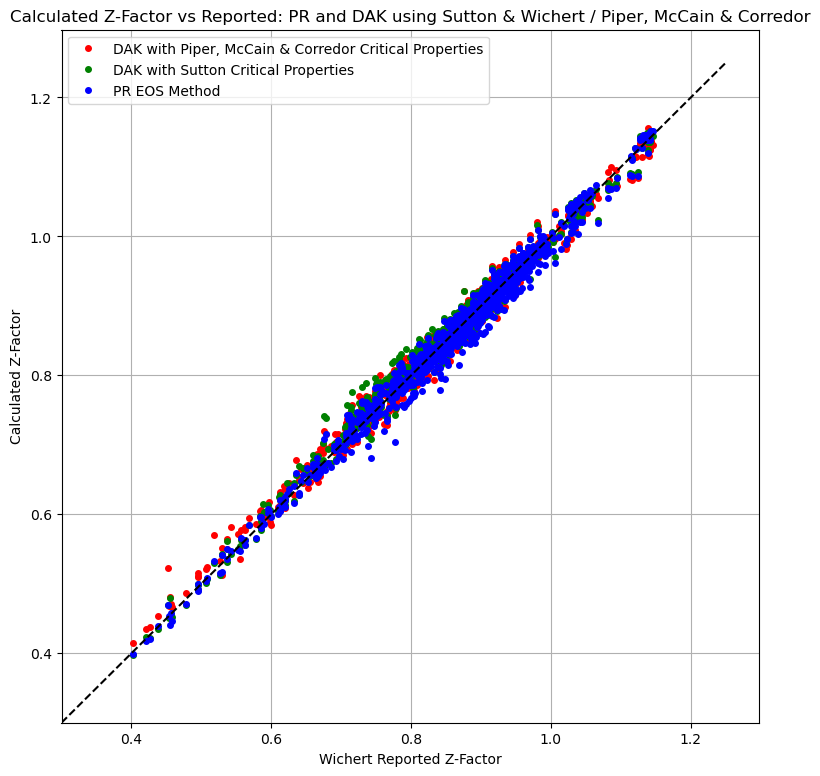

In [37]:
# Compare Wichert data only
df = pd.read_excel('Wichert_data_export4.xlsx')
filtered = df[df['Source'] == 'Wichert'].copy()

degfs = np.array(filtered['degf'])
psias = np.array(filtered['psia'])
sgs = np.array(filtered['sg'])
co2s = np.array(filtered['co2'])
h2ss = np.array(filtered['h2s'])
n2s = np.array(filtered['n2'])
Zs = np.array(filtered['Z'])

calc_Zs = []
for i in range(len(degfs)):
    calc_Zs.append(pr_z.peng_robinson_z(degfs[i], psias[i], sgs[i], co2=co2s[i], h2s=h2ss[i], n2=n2s[i]))
calc_Zs = np.array(calc_Zs)

z_dak_pmc = np.array([rtb.gas_z(psias[i], sgs[i], degfs[i], zmethod='DAK', cmethod='PMC', co2 = co2s[i], h2s = h2ss[i], n2 = n2s[i] ) for i in range(len(psias))])
z_dak_sut = np.array([rtb.gas_z(psias[i], sgs[i], degfs[i], zmethod='DAK', cmethod='SUT', co2 = co2s[i], h2s = h2ss[i], n2 = n2s[i] ) for i in range(len(psias))])



plt.plot(Zs, z_dak_pmc, 'o', c='r', markersize=4, label='DAK with Piper, McCain & Corredor Critical Properties')
plt.plot(Zs, z_dak_sut, 'o', c='g', markersize=4, label='DAK with Sutton Critical Properties')
plt.plot(Zs, calc_Zs, 'o', c='b', markersize=4, label='PR EOS Method')

plt.xlabel('Wichert Reported Z-Factor')
plt.ylabel('Calculated Z-Factor')
plt.plot([0.3, 1.25], [0.3, 1.25], '--', c='k')
plt.ylim(0.3, None)
plt.xlim(0.3, None)
plt.grid()
plt.title('Calculated Z-Factor vs Reported: PR and DAK using Sutton & Wichert / Piper, McCain & Corredor')

plt.legend(loc='upper left')
plt.savefig('images\\'+'Crossplot_Z-PR_DAK.png')
plt.show()

In [38]:
pr_er = (calc_Zs - Zs)/Zs
dak_sut_err = (z_dak_sut - Zs)/Zs
dak_pmc_err = (z_dak_pmc - Zs)/Zs

errs = [pr_er, dak_sut_err, dak_pmc_err]
names = ['Peng Robinson', 'DAK + Sutton & Wichert', 'DAK + PMC']
for e, err in enumerate(errs):
    avg = np.mean(err)
    maxerr = max(err)
    print(names[e], 'Avg Rel. Error: '+str(round(avg, 3))+', Max rel. Error: '+str(round(maxerr, 3))+', 95% Errors less than ', str(round(np.percentile(err, 95),4)))

Peng Robinson Avg Rel. Error: -0.003, Max rel. Error: 0.055, 95% Errors less than  0.0242
DAK + Sutton & Wichert Avg Rel. Error: 0.007, Max rel. Error: 0.097, 95% Errors less than  0.0336
DAK + PMC Avg Rel. Error: 0.004, Max rel. Error: 0.157, 95% Errors less than  0.0349


              psia         Z      degf       co2       h2s        n2  \
psia      1.000000  0.292393  0.234101 -0.087336  0.014026  0.080536   
Z         0.292393  1.000000  0.370185  0.010425 -0.584901 -0.013262   
degf      0.234101  0.370185  1.000000 -0.091556  0.014794  0.159696   
co2      -0.087336  0.010425 -0.091556  1.000000 -0.196992 -0.073442   
h2s       0.014026 -0.584901  0.014794 -0.196992  1.000000  0.065775   
n2        0.080536 -0.013262  0.159696 -0.073442  0.065775  1.000000   
sg_hc     0.341707  0.220182  0.398276 -0.076788 -0.157621  0.333616   
Residual  0.215267 -0.107312  0.013414  0.167959 -0.001828  0.051046   

             sg_hc  Residual  
psia      0.341707  0.215267  
Z         0.220182 -0.107312  
degf      0.398276  0.013414  
co2      -0.076788  0.167959  
h2s      -0.157621 -0.001828  
n2        0.333616  0.051046  
sg_hc     1.000000 -0.264189  
Residual -0.264189  1.000000  


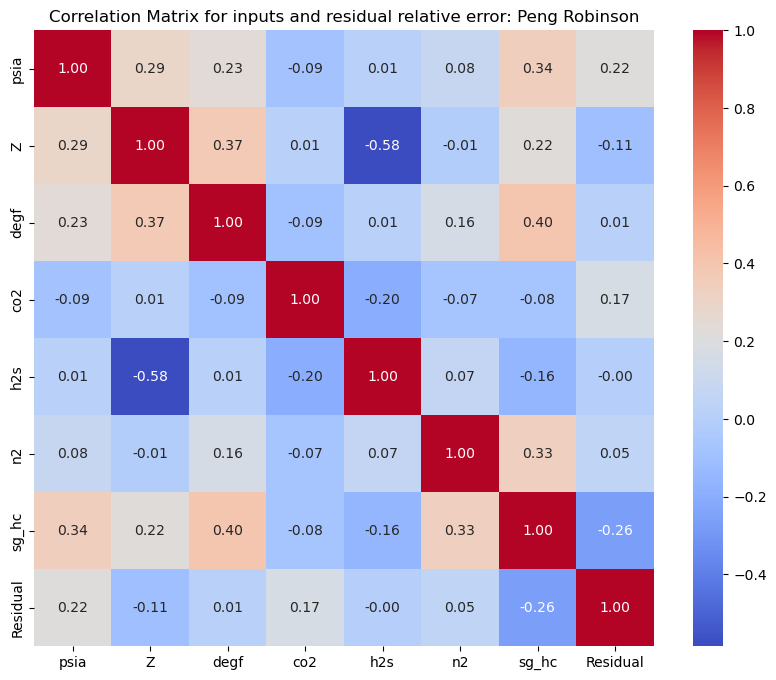

In [39]:
# Peng Robinson
errs = pr_er
cor_df = filtered.copy()
to_drop = ['Sample', 'Source', 'C1', 'C2', 'C3', 'iC4', 'nC4', 'iC5', 'nC5', 'C6', 'C7', 'C8', 'C9', 'C10']
for drop in to_drop:
    try:
        cor_df.drop(columns = [drop], inplace=True)
        cor_df['sg_hc'] = (cor_df['sg'] - (cor_df['co2'] * 44.01 + cor_df['h2s'] * 34.082 + cor_df['n2'] * 28.014) / 28.97) / (1 - df['co2'] - df['h2s'] - df['n2'])
        cor_df.drop(columns = ['sg'], inplace=True)
    except:
        pass

cor_df['Residual'] = errs
correlation_matrix = cor_df.corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for inputs and residual relative error: Peng Robinson')
plt.savefig('images\\'+'corel_wichert_PR.png')
plt.show()

              psia         Z      degf       co2       h2s        n2  \
psia      1.000000  0.292393  0.234101 -0.087336  0.014026  0.080536   
Z         0.292393  1.000000  0.370185  0.010425 -0.584901 -0.013262   
degf      0.234101  0.370185  1.000000 -0.091556  0.014794  0.159696   
co2      -0.087336  0.010425 -0.091556  1.000000 -0.196992 -0.073442   
h2s       0.014026 -0.584901  0.014794 -0.196992  1.000000  0.065775   
n2        0.080536 -0.013262  0.159696 -0.073442  0.065775  1.000000   
sg_hc     0.341707  0.220182  0.398276 -0.076788 -0.157621  0.333616   
Residual -0.164524 -0.266585 -0.212475  0.167026 -0.164870  0.006051   

             sg_hc  Residual  
psia      0.341707 -0.164524  
Z         0.220182 -0.266585  
degf      0.398276 -0.212475  
co2      -0.076788  0.167026  
h2s      -0.157621 -0.164870  
n2        0.333616  0.006051  
sg_hc     1.000000 -0.132556  
Residual -0.132556  1.000000  


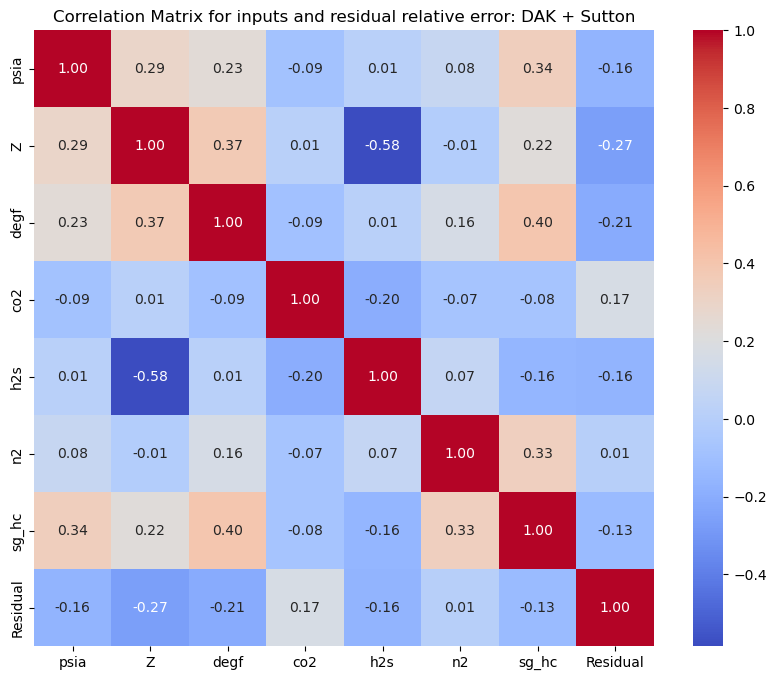

In [40]:
# DAK + Sutton & Wichert
errs = dak_sut_err

cor_df['Residual'] = errs
correlation_matrix = cor_df.corr()
print(correlation_matrix)


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for inputs and residual relative error: DAK + Sutton')
plt.savefig('images\\'+'corel_wichert_DAK_Sutton.png')
plt.show()

              psia         Z      degf       co2       h2s        n2  \
psia      1.000000  0.292393  0.234101 -0.087336  0.014026  0.080536   
Z         0.292393  1.000000  0.370185  0.010425 -0.584901 -0.013262   
degf      0.234101  0.370185  1.000000 -0.091556  0.014794  0.159696   
co2      -0.087336  0.010425 -0.091556  1.000000 -0.196992 -0.073442   
h2s       0.014026 -0.584901  0.014794 -0.196992  1.000000  0.065775   
n2        0.080536 -0.013262  0.159696 -0.073442  0.065775  1.000000   
sg_hc     0.341707  0.220182  0.398276 -0.076788 -0.157621  0.333616   
Residual -0.146988 -0.396748 -0.117471 -0.135898  0.192306  0.181971   

             sg_hc  Residual  
psia      0.341707 -0.146988  
Z         0.220182 -0.396748  
degf      0.398276 -0.117471  
co2      -0.076788 -0.135898  
h2s      -0.157621  0.192306  
n2        0.333616  0.181971  
sg_hc     1.000000  0.017156  
Residual  0.017156  1.000000  


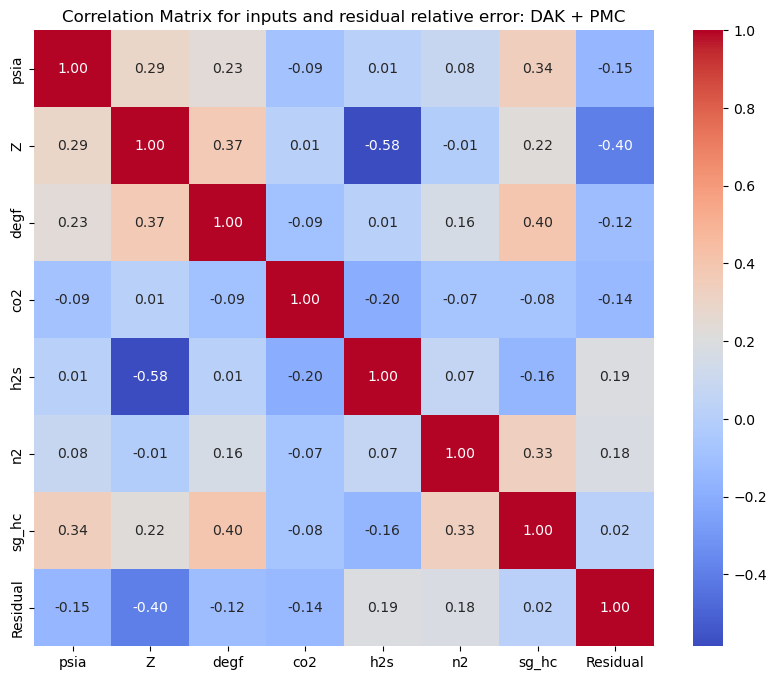

In [41]:
# DAK + PMC
errs = dak_pmc_err

cor_df['Residual'] = errs
correlation_matrix = cor_df.corr()
print(correlation_matrix)


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for inputs and residual relative error: DAK + PMC')
plt.savefig('images\\'+'corel_wichert_DAK_PMC.png')
plt.show()

Text(0.5, 1.0, 'CO2 Fraction Histogram')

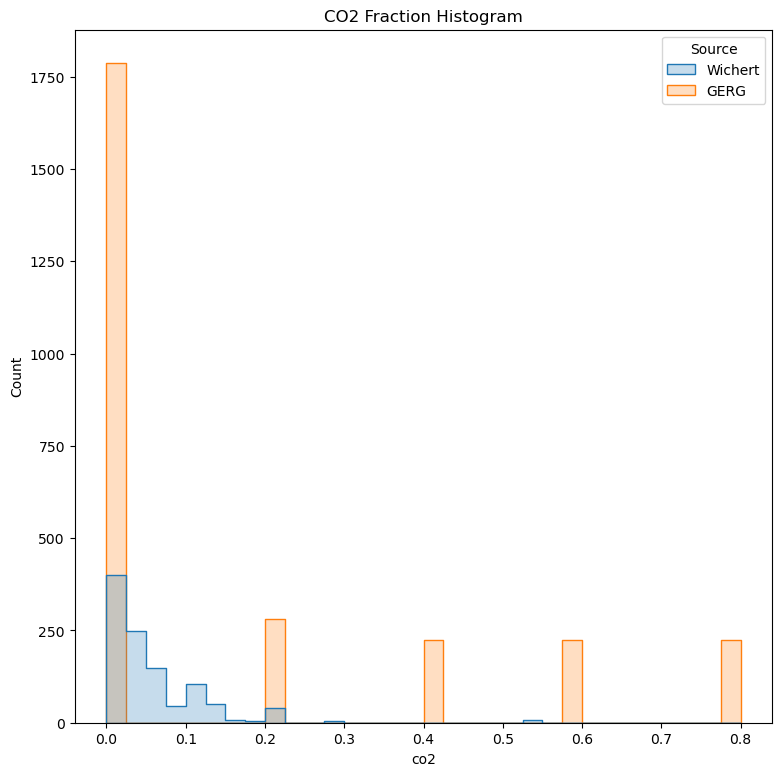

In [42]:
# plot overlapping histograms
sns.histplot(df, x='co2', hue='Source', element="step")
plt.title('CO2 Fraction Histogram')

Text(0.5, 1.0, 'H2S Fraction Histogram')

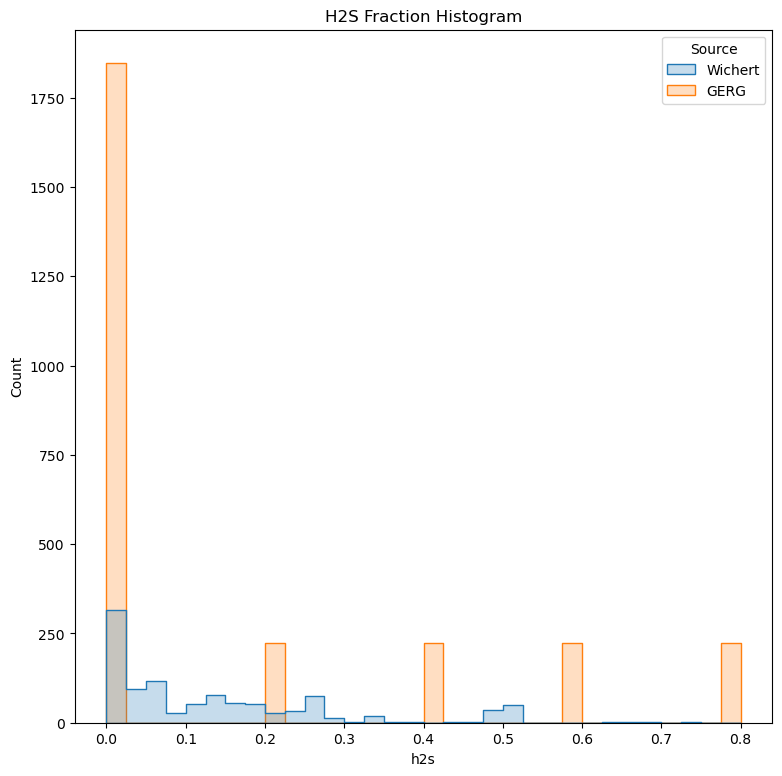

In [43]:
# plot overlapping histograms
sns.histplot(df, x='h2s', hue='Source', element="step")
plt.title('H2S Fraction Histogram')

Text(0.5, 1.0, 'N2 Fraction Histogram')

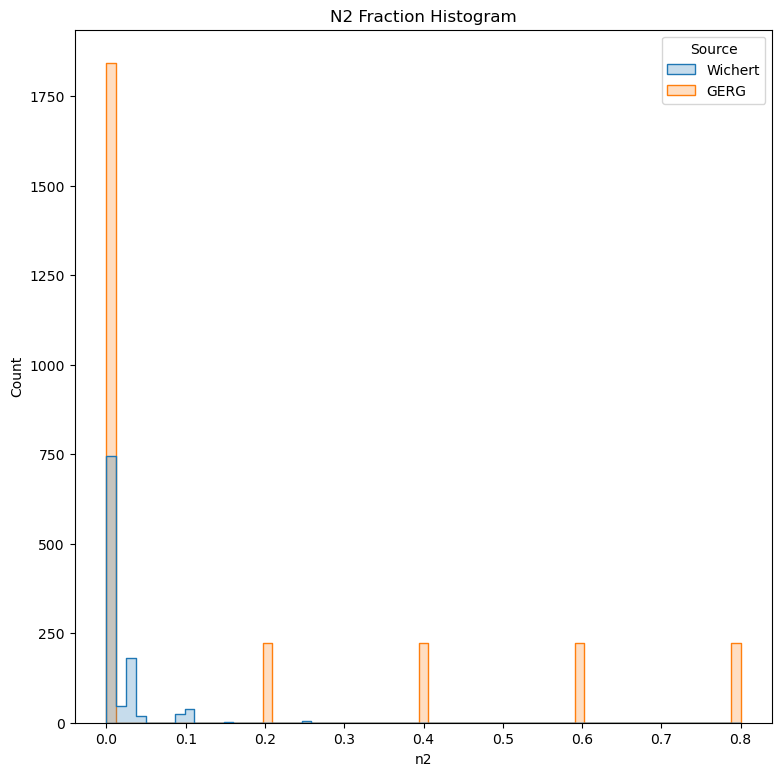

In [44]:
# plot overlapping histograms
sns.histplot(df, x='n2', hue='Source', element="step")
plt.title('N2 Fraction Histogram')

In [45]:
# Read in the interpolated digitized S&K data
df_sk = pd.read_excel('..\\S&K Redigitized by MBurgoyne.xlsx', sheet_name='v2_Interpolated')
trs = np.array(df_sk['Tr'])
prs = np.array(df_sk['Pr'])
sk_zs = np.array(df_sk['Z'])

In [46]:
tc, pc, mw = 343.008, 667.029, 16.043 # Methane
calc_Zs = []
for i in range(len(trs)):
    degf = trs[i]*tc - 459.67
    psia = prs[i] * pc
    calc_Zs.append(pr_z.peng_robinson_z(degf, psia, sg=mw/28.97, co2=0, h2s=0, n2=0, h2=0))

errs = [(sk_zs[i] - calc_Zs[i])/sk_zs[i] for i in range(len(trs))]

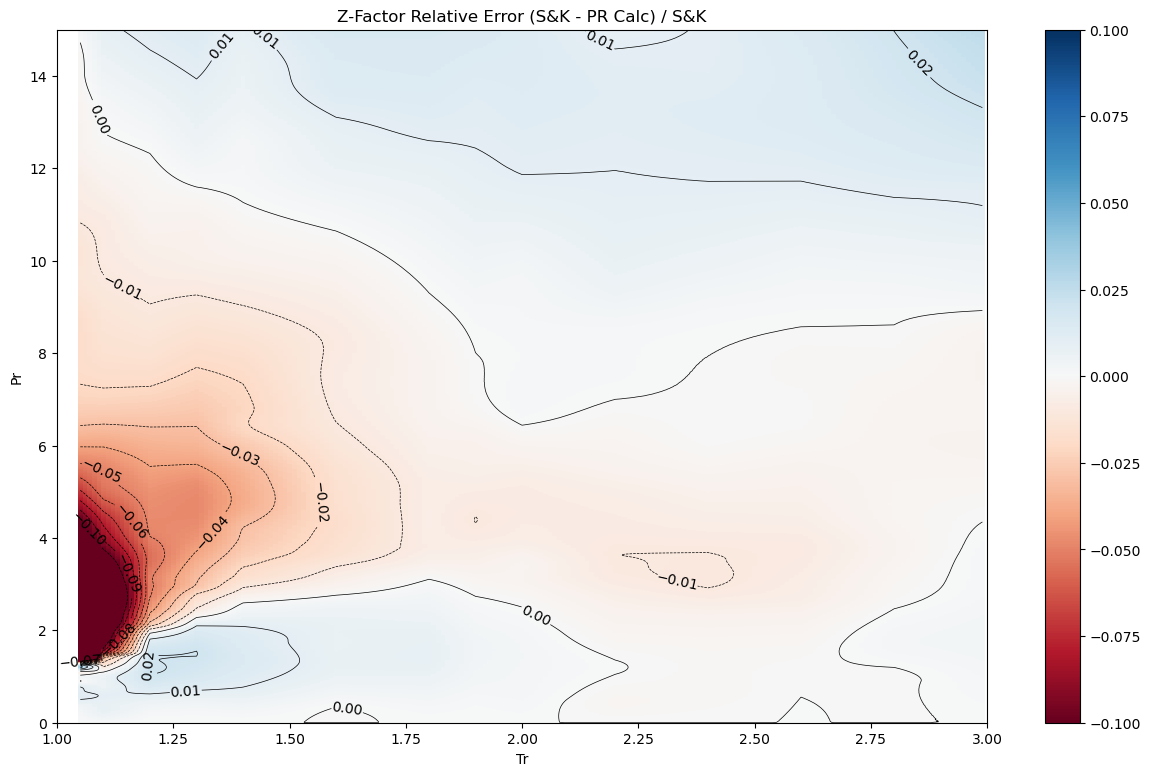

In [47]:
x = trs
y = prs
z = errs
    
# target grid to interpolate to
yi = np.arange(0, 15,0.01)
xi = np.arange(1.05, 3.0, 0.01)
xi,yi = np.meshgrid(xi,yi)

# interpolate
zi = griddata((x,y), z, (xi,yi),method='linear')

rcParams['figure.figsize'] = 15, 9
fig, ax = plt.subplots()
#c = ax.pcolormesh(xi, yi, zi, cmap='RdBu', vmin=zi.min(), vmax=zi.max())
c = ax.pcolormesh(xi, yi, zi, cmap='RdBu', vmin=-0.1, vmax=0.1)
levels = np.arange(-0.1, 0.11, 0.01)
CS = ax.contour(xi, yi, zi, levels=levels, linewidths=0.5, colors='k')
ax.clabel(CS, inline=True, fontsize=10)

ax.set_title('Z-Factor Relative Error (S&K - PR Calc) / S&K')
# set the limits of the plot to the limits of the data
ax.axis([xi.min(), xi.max(), yi.min(), yi.max()])
ax.set_ylabel('Pr')
ax.set_xlabel('Tr')
ax.set_ylim(0, 15)
ax.set_xlim(1.0, 3.0 )
fig.colorbar(c, ax=ax)
plt.savefig('images\\S&K_Rel_Error_vs_PR.png')
plt.show()

## And contrast with DAK Correlation

In [48]:
tc, pc, mw = 343.008, 667.029, 16.043 # Methane
DAK_calc_Zs = []
for i in range(len(trs)):
    degf = trs[i]*tc - 459.67
    psia = prs[i] * pc
    DAK_calc_Zs.append(rtb.gas_z(psia, 0.75, degf, zmethod='DAK', cmethod='SUT', co2 = 0, h2s = 0, n2 = 0, tc = tc, pc = pc))

errs2 = [(sk_zs[i] - DAK_calc_Zs[i])/sk_zs[i] for i in range(len(trs))]

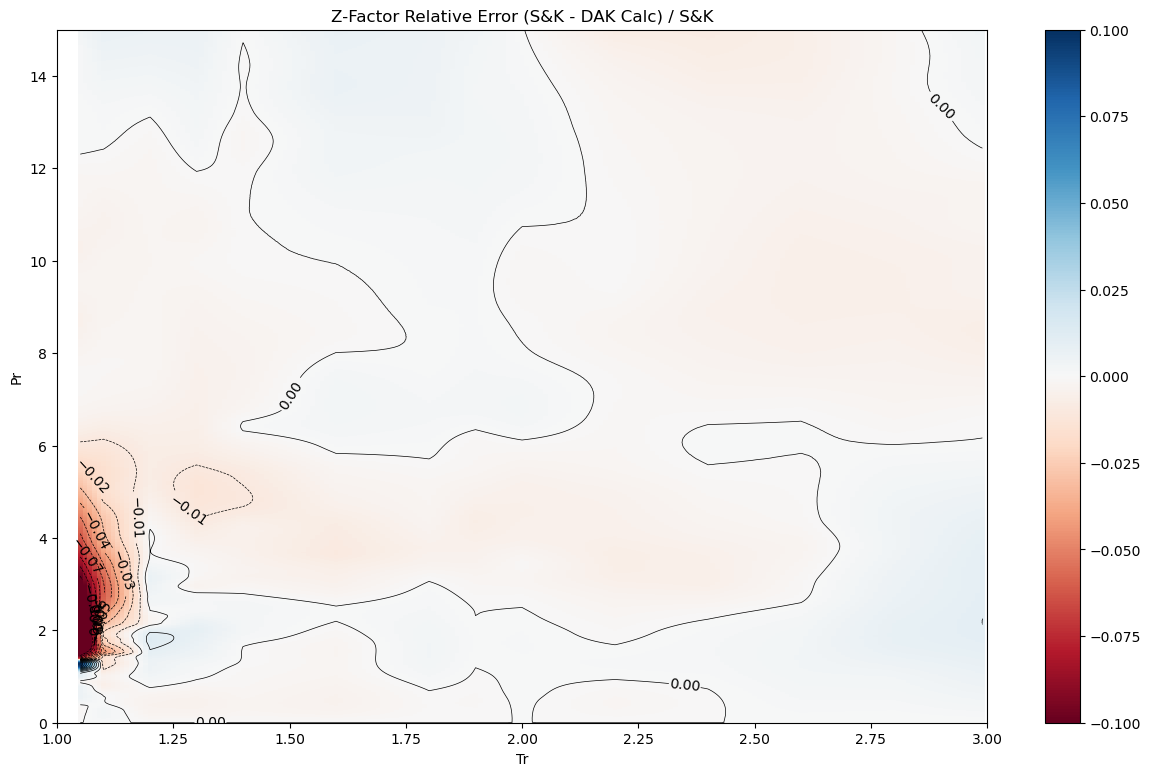

In [49]:
x = trs
y = prs
z = errs2
    
# target grid to interpolate to
yi = np.arange(0, 15,0.01)
xi = np.arange(1.05, 3.0, 0.01)
xi,yi = np.meshgrid(xi,yi)

# interpolate
zi = griddata((x,y), z, (xi,yi),method='linear')

rcParams['figure.figsize'] = 15, 9
fig, ax = plt.subplots()
#c = ax.pcolormesh(xi, yi, zi, cmap='RdBu', vmin=zi.min(), vmax=zi.max())
c = ax.pcolormesh(xi, yi, zi, cmap='RdBu', vmin=-0.1, vmax=0.1)
levels = np.arange(-0.1, 0.11, 0.01)
CS = ax.contour(xi, yi, zi, levels=levels, linewidths=0.5, colors='k')
ax.clabel(CS, inline=True, fontsize=10)

ax.set_title('Z-Factor Relative Error (S&K - DAK Calc) / S&K')
# set the limits of the plot to the limits of the data
ax.axis([xi.min(), xi.max(), yi.min(), yi.max()])
ax.set_ylabel('Pr')
ax.set_xlabel('Tr')
ax.set_ylim(0, 15)
ax.set_xlim(1.0, 3.0 )
fig.colorbar(c, ax=ax)
plt.savefig('images\\S&K_Rel_Error_vs_DAK.png')
plt.show()